# Analysis of Airplane Crashes since 1990

# Overview

In this project, we attempted to determine what are some factors that could lead to crashes. Our analysis had 3 main approaches

- We first used a topic clustering algorithm known as Latent Dirichlet Allocation to group the dataset into 3 major topics, which we found to be: Hardware/Fuel failure, Communication/Crew issues and Weather/Altitude issues. 

- We next used a Linear Regression based analysis as well as a T-Test resulting in a very weak correlation/no significant evidence that there was a correlation b/w the number of fatalities and the nominal GDP of a country

- Finally we use a Chi Squared test which indicated there was strong significant evidence that there was a correlation b/w the likelihood of an airplane crash and the time of the day (specifically there were more crashes happening during the daytime)

# Names

* Advitya Gemawat
* Catherine Hou
* Devanshu Desai
* Kaixin Huang
* Siddharth Saha

<a id='research_question'></a>
# Research Question

What are the major factors noticed during crashes?

Does a country with higher GDP contribute to a higher average fatalities among airline crashes?

Does the likelihood of an airline crash depend on the daylight conditions in that timezone?

<a id='background'></a>

## Background & Prior Work

We often hear that flying is the safest way to travel, that the odds of being in a plane crash are significantly smaller than being in a car accident. With new safety protocols and advancements in technology, flying should be safer. But incidents with planes such as the Boeing 737, where 2 crashes killed 346 people [4], cast doubt when people have heightened anxiety and unease towards flying in the aftermath of lost lives. So we want to use data to explain if there are features that are more correlated with crashes than others to explain what makes a flight more risky than others.

One GitHub project did an exploratory analysis on airplane crashes for cities. They found that planes departing from New York City, Rome, and Chicago had the highest number of crashes. This is slightly different from the highest number of crashes for cities planes are arriving to, which is Paris, New York City, and London. They also found that weather plays a huge role in the likelihood of an airplane crashing. [1] This project supports the idea that there are multiple features that we can look at to determine how at risk is a flight based on past crashes. To futher the analysis in this past work, we plan to look at other major factors noticed during crashes in our analysis, like communication issues to supplement what features contribute the most to airplane crashes.

One Kaggle project focused on finding trends in flight crashes. They found that planes that fly over the Canary Islands or Japan are associated with the highest numer of crashes. The data included civil, commercial, and military transport flights from 1908-2009 [3]. This and the previous work discussed support how location matters when it comes to the safety of a flight. Now that we know that certain areas of the world have more accidents, we want to add another layer to this analysis, by not only looking at the specific areas in the world, but also the GDP of those countries, to see if countries with higher GDP have higher average fatalities.

Another GitHub project does an exploratory analysis on civil aviation accidents within primarily the United States. The results show that the number of accidents follows a decreasing trend from 1982-2020. June and July are months when accidents happen the most because more flights are scheduled in the summer [2]. This shows that not only is location an important factor in how at risk a flight is, but also timing. We plan to drill down from time of year to time of day, to see if the likelihood of an airline crash depends on the daylight conditions in that timezone.

Airtravel is increasingly becoming an essential part of our lives, whether it is for work or for leisure. As our dependency on flying grows, so does our concerns for safety. More specifically we want to know what major factors are noticed during crashes, the how the GDP of its destination country is connected, and how the daylight conditions in that time zone are connected. We hope to find new insights in what factors contribute to a safer or riskier flight to know how at risk is a flight based on previous data. This could inform airlines of the most important factors to be thinking about when it comes to safety regulations, leading to safer travel for flight passengers.


References:

- 1)https://github.com/PrachiJain5/Airplane-Crash-Data-Analysis

- 2)https://github.com/andreantonacci/aviation-accidents

- 3)https://github.com/RohitLearner/Flight-Crash-Investigation

- 4)https://www.cnn.com/travel/article/boeing-737-story-behind-the-troubled-aircraft/index.html

# Hypothesis


We have 3 main hypothesis

- Based off our domain knowledge, we thought the most common factors for crashes would be hardware and really harsh weather

- We hypothesize that most of the airline crashes (purely by numbers) may have occurred in countries with higher GDPs simply because richer countries may tend to operate more flights, passengers etc.

- We hypothesize that planes crash more during the night due to poor visibility in those conditions

# Dataset(s)

1) *Airplane Crash Dataset*
 - https://data.world/data-society/airplane-crashes
 - 5268 observations
 - This is a dataset of all civilian and military airplane crashes recorded in history since 1908. This dataset was originally sourced by OpenData
 - We plan on subsetting this. Our research question has a limited scope of the past 30 years so as to not inwardly include any trends that have disappeared due to current progression in technology


2) *Nominal GDP Per Capita Dataset*
 - https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita
 - 218 observations
 - This is a dataset containing the last reported nominal GDP per capita for all the countries in our dataset. We use this to compare if the countries where the crash occurred was a rich or a relatively poor country.


3) *US States Dataset*
 - https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States
 - 50 observations
 - This is a dataset containing all the 50 states in the US. It's very simple but helps us with mapping out crash sites in the US correctly.

*How we plan to combine the datasets*
 - We plan to use the nominal GDP per capita to find the relative prosperitiy of the country where the crash occurred. We will join it with the airplane crash dataset on the `Country` (renamed from `Location`) column.
 - The US States dataset will be used to map the crash sit correctly if the `Country` (previously `Location`) is *North Carolina* for example. We can correctly map it to *United States* in such cases.
 - Rest will be cleaned using a custom mapping

# Setup

In [1]:
import warnings
import bs4
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

from scipy.stats import pearsonr, norm, ttest_ind
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import curve_fit

#!pip install gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
# nltk.download('wordnet')
#!pip install wordcloud
from wordcloud import WordCloud

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
np.random.seed(42)

### Constants

In [2]:
GDP_URL = (
    "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_"
    "per_capita"
)

STATES_URL = (
    "https://en.wikipedia.org/wiki/List_of_states_and_territories"
    "_of_the_United_States"
)
MAX_RETRIES = 3
UN_LOCATION = -1
COUNTRY_NAME_LOCATION = 1
GDP_LOCATION = 2
NUM_COLS = 3
YEARS_SUBSETTED = 1990
FP = 'Airplane_Crashes_and_Fatalities_Since_1908.csv'
EXCEPTION_REPLACES = {
    "Burma":"Myanmar", "Canary Islands":"Africa", "USSR":"Russia", \
    "Over the AtlantiOcean":np.NaN, "Mauretania":"Africa", \
    "West Germany":"Germany", "Bahamas":"The Bahamas", \
    "Zaire":"Democratic Republic of the Congo", "IN":"United States", \
    "Off Tabones Island  Philippines": "Philippines", \
    "Comoro Islands":"South Africa", "New Guinea":"Papua New Guinea", \
    "Taiwan":"China", "England":"United Kingdom", "Russian":"Russia", \
    "U.S. Virgin Islands":"United States","Saint Lucia Island":"Saint Lucia",\
    "AK":"United States", "D.C.":"United States", \
    "Massachusett":"United Kingdom", "Djbouti":"Africa", \
    "Gulf of Thailand":"Thailand", "South AtlantiOcean": "United Kingdom", \
    "PacifiOcean":"United States", "Alaksa":"United States", \
    "AtlantiOcean":np.NaN, "Off Taiwan":"China", \
    "Barquisimeto Venezuela":"Venezuela", "UK": "United Kingdom", \
    "UAE":"United Arab Emirates", "Off  Bimini": "The Bahamas", \
    "American Samoa":"Samoa", "110 miles West of Ireland":"Ireland", \
    "Soviet Union":"Russia", "Islay Island":"United Kingdom", \
    "Leeward Islands":"Saint Lucia", "Scotland":"United Kingdom", \
    "East Germany": "Germany", "Ivory Coast":"Africa", "Thiland":"Thailand",\
    "Indian Ocean":"Mauritius","Over the Andaman Sea":"United Arab Emirates",\
    "Eugene Island":"United States", "Central Mozambique":"Mozambique", \
    "Northern Afghanistan":"Afghanistan", \
    "Zaïre":"Democratic Republic of the Congo", "Surinam":"Suriname", \
    "Semyonovka ,Ukraine":"Ukraine", "Milford Sound":"New Zealand", \
    "Congo":"Republic of the Congo", "Sierre Leone": "Sierra Leone", \
    "Santiago de Cuba":"Cuba", \
    "Grenadines Islands":"Saint Vincent and the Grenadines", \
    "CA":"United States", "Airzona":"United States", \
    "Great Inagua":"The Bahamas", "NWT,Canada":"Canada", \
    "En route from Argentina  to  California":np.NaN, \
    "Wisconson":"United States", "Virgin Islands":"United States", \
    "Macedonia":"North Macedonia", \
    "Netherlands Antilles":"Netherlands", \
    "DemocratiRepubliCongo":"Democratic Republic of the Congo", \
    "Tennesee":"United States","Gambia":"The Gambia","Near Nag":"Armenia", \
    "Northern Iraq":"Iraq", "Martinique":"France", \
    "Inodnesia":"Indonesia","GA":"United States","Kirghizia":"Kyrgyzstan", \
    "Domincan Republic":"Dominican Republic", "Hati":"Haiti", \
    "Queensland  Australia":"Australia", "The Netherlands":"Netherlands", \
    "Manmar":"Myanmar", "Canada2":"Canada","Yugosalvia":"North Macedonia", \
    "Northern Israel":"Israel", "Guam":"United States", \
    "off Angola":"Angola", "Over the PacifiOcean":"Japan", \
    "Morroco":"Morocco","British Columbia":"Canada","Tasmania":"Australia",\
    "Cape Verde Islands":"Cape Verde", "Azores (Portugal)":"Portugal", \
    "Pepa ,Congo":"Democratic Republic of the Congo", \
    "Calilfornia":"United States", "BO":"Bolivia", \
    "Republiof Georgia":"Georgia", "French West Indies":"The Bahamas", \
    "Azores":"Portugal", "Virginia":"United States", \
    "Republiof Djibouti":"Djibouti", "Manitoba":"Canada", \
    "Chechnya":"Russia", "Comoros Islands":"Comoros", \
    "Sao Gabriel de Cachoeria":"Brazil", \
    "Bosnia-Herzegovina":"Bosnia and Herzegovina", \
    "Afghanstan":"Afghanistan", \
    "DemoctratiRepubliCongo":"Democratic Republic of the Congo", \
    "DemocratiRepubliCogo":"Democratic Republic of the Congo", \
    "Near Karkov":"Ukraine", \
    "Saskatchewan":"Canada","Off São Tomé Island":"São Tomé and Príncipe", \
    "Napal":"Nepal", "Turks & Caicos Islands":"United Kingdom", \
    "DR Congo":"Democratic Republic of the Congo", \
    "Black Sea":np.NaN, "Off Turks and Caicos Islands":"United Kingdom", \
    "Near Houma Louisiana":"United States", "Newfoundland":"United States", \
    "DemocratiRepubliof Congo":"Democratic Republic of the Congo", \
    "Virginia.":"United States"
}

Let's first read in the dataset

In [3]:
#Reading in raw dataframe
airplane_crashes_raw = pd.read_csv(FP)
airplane_crashes_raw.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


We can see that the date column has data from a lot of the early years. Let's filter our dataset to the subset of those crashes that happened past 1990

In [4]:
# Generating subset of dataframe for analysis on recent data
def generate_subset(airplane_crashes, year):
    return airplane_crashes[pd.to_datetime(airplane_crashes.Date).dt.year >= year].reset_index(drop = True)

airplane_crashes = generate_subset(airplane_crashes_raw, YEARS_SUBSETTED)
airplane_crashes.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,02/22/1991,NaN,"Cazombo, Angola",Fuerza Area Angolaise,NaN,NaN,Antonov AN-26,NaN,NaN,47.0,47.0,0.0,Shot down by surface-to-air missile launced by...
1,02/05/1990,08:37,"Near Ibague, Colombia",Helicopteros Nacionales de Colombia,NaN,Bogota via Neiva - Ibague,Grumman G-159 Gulfstream I,HK-3315X,024,15.0,15.0,0.0,"Struck Mt. El Saluda at 5,000 ft., near Image,..."
2,01/02/1990,13:40,"Java Sea, Indonesia",Pelita Air Service,NaN,Palambang and Jakarta,CASA 212 Aviocar 200,PK-PCM,217/57N,16.0,9.0,0.0,Ditched into the Java Sea after experiencing m...
3,01/13/1990,12:56,"Near Pervouralsk, Russia",Aeroflot,NaN,Tyumen - Ufa,Tupolev TU-134A,CCCP-65951,2351703,71.0,27.0,0.0,A fire in the rear cargo hold and fire warning...
4,01/15/1990,08:30,"Pico Blanco, Costa Rica",SANSA,032,San Jose - Palmar Sur,CASA 212 Aviocar 200,TI-SAB,163,23.0,23.0,0.0,"Crashed about 4,500 feet up on 7,250 ft. Pico ..."


Now that we have generated our subset let's get some basic information on the state of our dataset

Shape of dataframe is (1358, 13)
Here are the number of null values in each column


,Number of null values
Flight #,974
Time,302
Route,214
cn/In,118
Registration,65
Summary,16
Location,4
Ground,3
Type,3
Operator,3


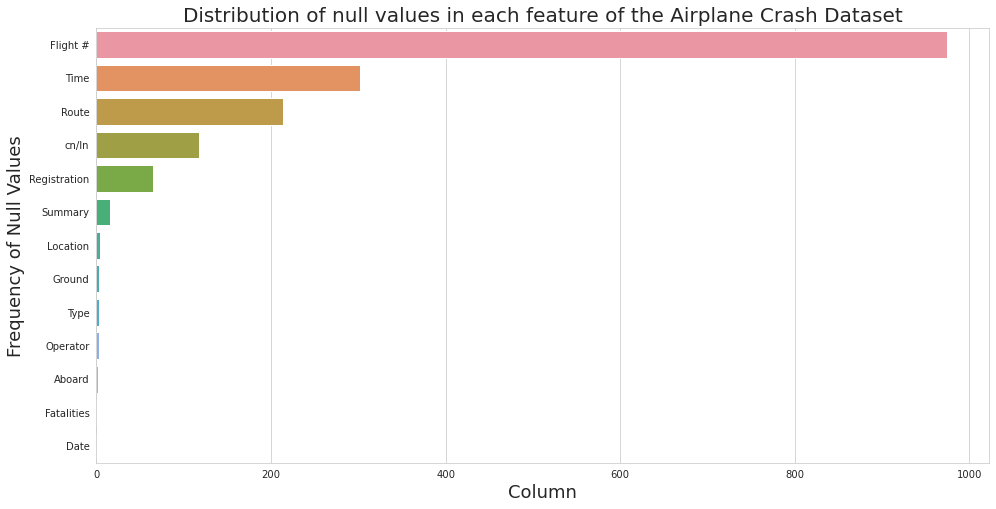

In [5]:
# Function to provide some basic information on missingness in a given dataset
def display_basic_data_info(airplane_crashes):
    print(f"Shape of dataframe is {airplane_crashes.shape}")
    print(f"Here are the number of null values in each column")
    # Get's number of null values per column
    columnar_null_info = airplane_crashes.isnull().sum().sort_values(ascending = False)
    columnar_null_info = columnar_null_info.to_frame() #Converts to dataframe
    columnar_null_info.columns = ['Number of null values']
    display(columnar_null_info) #Displays the dataframe
    columnar_null_info = columnar_null_info['Number of null values']
    # Plotting missingness by column
    _, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x=columnar_null_info.values, y=columnar_null_info.index, ax=ax);
    ax.set_title('Distribution of null values in each feature of the Airplane Crash Dataset', fontsize=20);
    ax.set_xlabel('Column', fontsize=18);
    ax.set_ylabel('Frequency of Null Values', fontsize=18);
display_basic_data_info(airplane_crashes)

We still have 1358 rows which we can use for analysis. There is a lot of null data though which we will have to take care of later. Since our question checks for any relation b/w airplane crashes and the nominal GDP of the nations we need to retrieve that data. We can scrape it from Wikipedia

In [6]:
def request_with_retries(url, max_retry, retry=1):
    """
    Keeps requesting until successful or hit the maximum allowed retries in max_retry
    Each subsequent retry takes longer then the earlier by an exponential amount
    """
    resp = requests.get(url)
    if resp.ok:
        return resp, retry # If our request was processed return the response
    elif retry <= max_retry:
        time.sleep(2**retry)  # Otherwise sleep and try again
        return request_with_retries(url, max_retry, retry=(retry + 1))
    else:
        return resp, retry # If we hit max tries return
    
def generate_gdp_data_per_country():
    resp, retry = request_with_retries(GDP_URL, MAX_RETRIES)
    if resp.ok: # Printing number of retries needed
        if retry != 1:
            print(f"Retrieved GDP data in {retry} attempts")
        else:
            print("Retrieved GDP data in 1 attempt")
        # Parsing web response
        soup = bs4.BeautifulSoup(resp.text, "html.parser")
        # Generating table content
        gdp_table = soup.find_all("table", attrs = \
            {"class":"wikitable sortable"})[UN_LOCATION]
        # Cleaning start tokens
        country_names = [country_name.text.strip("\xa0") for country_name in \
        gdp_table.find_all("td")[COUNTRY_NAME_LOCATION::NUM_COLS]]
        # Cleaning the names of the countries
        country_names = [country_part[0].strip() if len(country_part) == 1 \
            else " ".join(country_part[-1:] + [country_part[0]]).strip() for \
            country_part in [country.split(", ") for country in country_names]]
        # Cleaning GDP values
        gdp_values = [int(gdp.text.strip("\n").replace(",","").strip()) for \
        gdp in gdp_table.find_all("td")[GDP_LOCATION::NUM_COLS]]
        # Zip the 2 lists into a dictionary
        gdp_dict = {country_names[i]:gdp_values[i] for i in range(\
            len(gdp_values))}
        # Create dataframe from dictionary with columns
        gdp_data = pd.DataFrame(gdp_dict.items(), columns = ["Country", "Nominal GDP Per Capita in US Dollars"])
        return gdp_data
    else:
        print(
            f"Failed to retrieve GDP data after {MAX_RETRIES}. "
            "Try again later"
        )
# Generate the GDP data
gdp_data = generate_gdp_data_per_country()
gdp_data.head()

Retrieved GDP data in 1 attempt


,Country,Nominal GDP Per Capita in US Dollars
0,Monaco,190532
1,Liechtenstein,179258
2,Luxembourg,115481
3,Bermuda,117768
4,Cayman Islands,92692


We now have loaded in the necessary data. Let's proceed and see how we can clean the data

# Data Cleaning

## Cleaning Up Locations

One of the most important features in the dataset relevant to our research questions is the location. Let's print some basic information of each frame

Shape of dataframe is (1358, 13)
Here are the number of null values in each column


,Number of null values
Flight #,974
Time,302
Route,214
cn/In,118
Registration,65
Summary,16
Location,4
Ground,3
Type,3
Operator,3


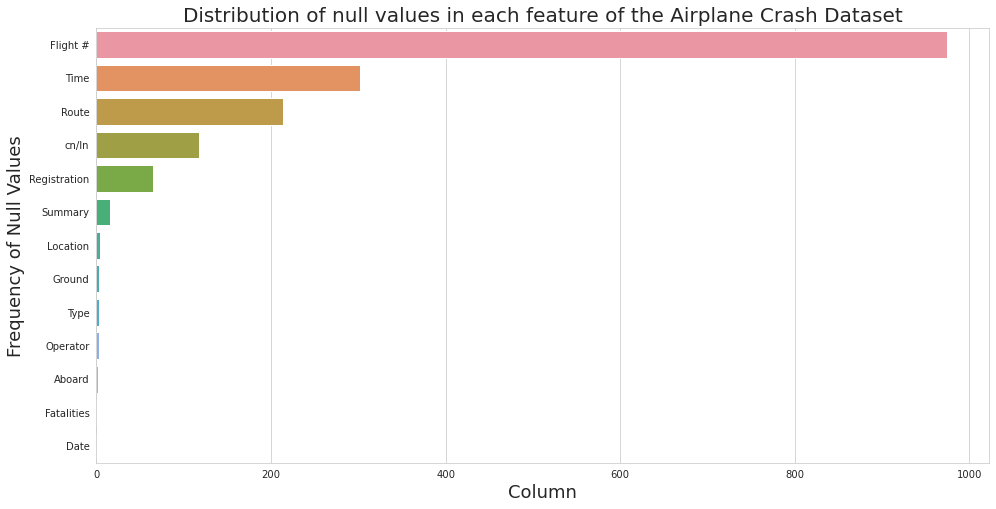

In [7]:
display_basic_data_info(airplane_crashes)

In [8]:
# Displays missingness information in GDP Data
print(f"Shape of dataframe is {gdp_data.shape}")
print(f"Here are the number of null values in each column")
columnar_null_info = gdp_data.isnull().sum().sort_values(ascending = False)
columnar_null_info = columnar_null_info.to_frame()
columnar_null_info.columns = ['Number of null values']
display(columnar_null_info)

Shape of dataframe is (217, 2)
Here are the number of null values in each column


,Number of null values
Nominal GDP Per Capita in US Dollars,0
Country,0


The GDP has no null data whereas the aircrash dataset has a lot more variance in it's features null distribution. Let' first set the column names of the common column to be the same to follow tidy data conventions.

In [9]:
# Renaming location to country
airplane_crashes["Country"] = airplane_crashes["Location"]
airplane_crashes.drop(columns = ["Location"], inplace = True)
airplane_crashes.head()

,Date,Time,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Country
0,02/22/1991,NaN,Fuerza Area Angolaise,NaN,NaN,Antonov AN-26,NaN,NaN,47.0,47.0,0.0,Shot down by surface-to-air missile launced by...,"Cazombo, Angola"
1,02/05/1990,08:37,Helicopteros Nacionales de Colombia,NaN,Bogota via Neiva - Ibague,Grumman G-159 Gulfstream I,HK-3315X,024,15.0,15.0,0.0,"Struck Mt. El Saluda at 5,000 ft., near Image,...","Near Ibague, Colombia"
2,01/02/1990,13:40,Pelita Air Service,NaN,Palambang and Jakarta,CASA 212 Aviocar 200,PK-PCM,217/57N,16.0,9.0,0.0,Ditched into the Java Sea after experiencing m...,"Java Sea, Indonesia"
3,01/13/1990,12:56,Aeroflot,NaN,Tyumen - Ufa,Tupolev TU-134A,CCCP-65951,2351703,71.0,27.0,0.0,A fire in the rear cargo hold and fire warning...,"Near Pervouralsk, Russia"
4,01/15/1990,08:30,SANSA,032,San Jose - Palmar Sur,CASA 212 Aviocar 200,TI-SAB,163,23.0,23.0,0.0,"Crashed about 4,500 feet up on 7,250 ft. Pico ...","Pico Blanco, Costa Rica"


Now let's compare the differences in Location for both DataFrames

In [10]:
# Finding the difference b/w the 2 country columns in the respective dataset for cleaning
def difference_in_locations(airplane_crashes, gdp_data):
    """
    Generates the differences b/w the 2 datasets. Differences are just those country values
    that lie in only 1 dataframe
    """
    # Finds the differences
    diffs = np.setdiff1d(airplane_crashes.Country.str.split(", ").str[-1].str.strip().unique(), \
                         gdp_data.Country.unique(), assume_unique = True)
    # Prints nubmer of differences
    if len(diffs) == 1:
        print(f"There is only 1 difference")
    else:
        print(f"There are {len(diffs)} differences")
    display(diffs)
    
difference_in_locations(airplane_crashes, gdp_data)

There are 121 differences


array(['Colorado', 'Ohio', 'New York', 'Congo', 'Vermont', 'Florida',
       'Sierre Leone', 'Santiago de Cuba', 'Zaire', 'England', 'Alaska',
       'Washington', 'New Guinea', 'Grenadines Islands', 'USSR', 'Taiwan',
       'Wisconsin', 'California', 'Michigan', 'Alabama', 'CA', 'Bahamas',
       'Pennsylvania', 'Airzona', 'Great Inagua', 'Idaho', nan, 'Oregon',
       'Texas', 'NWT,Canada', 'Nevada', 'Arizona', 'Indiana',
       'En route from Argentina  to  California', 'Tennessee', 'Hawaii',
       'North Carolina', 'Wisconson', 'Virgin Islands', 'Macedonia',
       'Illinois', 'Netherlands Antilles', 'West Virginia', 'Montana',
       'Utah', 'DemocratiRepubliCongo', 'New Mexico', 'Tennesee', 'Iowa',
       'Gambia', 'Nebraska', 'Minnesota', 'Near Nag', 'Scotland',
       'Northern Iraq', 'Connecticut', 'Virginia', 'Ivory Coast',
       'Martinique', 'New Jersey', 'Missouri', 'PacifiOcean', 'Alaksa',
       'Inodnesia', 'GA', 'Kirghizia', 'Domincan Republic', 'Hati',
       'Wyomi

We can see that a lot of these are US State Names. We could hardcode it but a better way would be to scrape it from Wikipedia again

In [11]:
def generate_US_state_names():
    resp, retry = request_with_retries(STATES_URL, MAX_RETRIES)
    if resp.ok: # Print number of attempts needed to get state dataset
        if retry != 1:
            print(f"Retrieved State names in {retry} attempts")
        else:
            print("Retrieved State names in 1 attempt")
        # Create parser for response
        soup = bs4.BeautifulSoup(resp.text, "html.parser")
        # Generating table information
        states_table = soup.find("table", attrs = {'class':\
            'wikitable sortable plainrowheaders'})
        # Cleaning states names
        states = [state.text.replace("[E]", "").strip() for state in \
        states_table.find_all('th', attrs={'scope':'row'})]
        # Returning list
        return states
    else:
        print(
            f"Failed to retrieve state names after {MAX_RETRIES}. "
            "Try again later"
        )

state_names = generate_US_state_names()
state_names[:5]

Retrieved State names in 1 attempt


['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California']

Now that we have successfully loaded in state information let's replace all the states in the airplane_crash dataset with the country 'United States'

In [12]:
def convert_state_to_country(airplane_crashes, state_names):
    # Use generated state information to convert US states to United States in our dataset
    airplane_crashes["Country"] = airplane_crashes["Country"].str.split(", ").str[-1].str.strip().apply(\
        lambda x: 'United States' if x in state_names else x)
    return airplane_crashes

airplane_crashes = convert_state_to_country(airplane_crashes, state_names)
airplane_crashes.head()

,Date,Time,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Country
0,02/22/1991,NaN,Fuerza Area Angolaise,NaN,NaN,Antonov AN-26,NaN,NaN,47.0,47.0,0.0,Shot down by surface-to-air missile launced by...,Angola
1,02/05/1990,08:37,Helicopteros Nacionales de Colombia,NaN,Bogota via Neiva - Ibague,Grumman G-159 Gulfstream I,HK-3315X,024,15.0,15.0,0.0,"Struck Mt. El Saluda at 5,000 ft., near Image,...",Colombia
2,01/02/1990,13:40,Pelita Air Service,NaN,Palambang and Jakarta,CASA 212 Aviocar 200,PK-PCM,217/57N,16.0,9.0,0.0,Ditched into the Java Sea after experiencing m...,Indonesia
3,01/13/1990,12:56,Aeroflot,NaN,Tyumen - Ufa,Tupolev TU-134A,CCCP-65951,2351703,71.0,27.0,0.0,A fire in the rear cargo hold and fire warning...,Russia
4,01/15/1990,08:30,SANSA,032,San Jose - Palmar Sur,CASA 212 Aviocar 200,TI-SAB,163,23.0,23.0,0.0,"Crashed about 4,500 feet up on 7,250 ft. Pico ...",Costa Rica


Let's reprint the differences in location again

In [13]:
(difference_in_locations(airplane_crashes, gdp_data))

There are 76 differences


array(['Congo', 'Sierre Leone', 'Santiago de Cuba', 'Zaire', 'England',
       'New Guinea', 'Grenadines Islands', 'USSR', 'Taiwan', 'CA',
       'Bahamas', 'Airzona', 'Great Inagua', nan, 'NWT,Canada',
       'En route from Argentina  to  California', 'Wisconson',
       'Virgin Islands', 'Macedonia', 'Netherlands Antilles',
       'DemocratiRepubliCongo', 'Tennesee', 'Gambia', 'Near Nag',
       'Scotland', 'Northern Iraq', 'Ivory Coast', 'Martinique',
       'PacifiOcean', 'Alaksa', 'Inodnesia', 'GA', 'Kirghizia',
       'Domincan Republic', 'Hati', 'Queensland  Australia',
       'The Netherlands', 'Manmar', 'Canada2', 'Yugosalvia',
       'Northern Israel', 'Guam', 'off Angola', 'Over the PacifiOcean',
       'Morroco', 'British Columbia', 'Tasmania', 'Cape Verde Islands',
       'Azores (Portugal)', 'Pepa ,Congo', 'Calilfornia', 'BO',
       'Republiof Georgia', 'French West Indies', 'Azores', 'Virginia.',
       'Republiof Djibouti', 'Manitoba', 'Chechnya', 'Comoros Islands',
  

These now need to be cleaned manually since there is no reliable way to clean all of them accurately through automation. You can see the differences in [Constants](#Constants). This will work for our dataset for years >= 1980

In [14]:
def clean_remaining_locations(airplane_crashes):
    # Cleaning remaining countries using hardcoded dictionary
    airplane_crashes["Country"] = airplane_crashes["Country"].replace(EXCEPTION_REPLACES)
    return airplane_crashes
airplane_crashes = clean_remaining_locations(airplane_crashes)
airplane_crashes.head()

,Date,Time,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Country
0,02/22/1991,NaN,Fuerza Area Angolaise,NaN,NaN,Antonov AN-26,NaN,NaN,47.0,47.0,0.0,Shot down by surface-to-air missile launced by...,Angola
1,02/05/1990,08:37,Helicopteros Nacionales de Colombia,NaN,Bogota via Neiva - Ibague,Grumman G-159 Gulfstream I,HK-3315X,024,15.0,15.0,0.0,"Struck Mt. El Saluda at 5,000 ft., near Image,...",Colombia
2,01/02/1990,13:40,Pelita Air Service,NaN,Palambang and Jakarta,CASA 212 Aviocar 200,PK-PCM,217/57N,16.0,9.0,0.0,Ditched into the Java Sea after experiencing m...,Indonesia
3,01/13/1990,12:56,Aeroflot,NaN,Tyumen - Ufa,Tupolev TU-134A,CCCP-65951,2351703,71.0,27.0,0.0,A fire in the rear cargo hold and fire warning...,Russia
4,01/15/1990,08:30,SANSA,032,San Jose - Palmar Sur,CASA 212 Aviocar 200,TI-SAB,163,23.0,23.0,0.0,"Crashed about 4,500 feet up on 7,250 ft. Pico ...",Costa Rica


Let's now once again see the differences

In [15]:
difference_in_locations(airplane_crashes, gdp_data) #Viewing the final difference

There is only 1 difference


array([nan], dtype=object)

We have now successfully cleaned our country column. Our dataset also follows Tidy Data Conventions as 
- Each row is measuring an observation
- Each column represents a feature
- Different information is stored in two different datasets
- The different datasets can be joined through a common column "Country"
- Data is rectangular

## Selecting & Dropping
The columns necessary to explore our research question are `Date`, `Aboard`, `Fatalities`, `Country`.

The columns `Flight #`, `cn/In`, `Registration` and `Ground` are not relevant to our research question, so we will drop them from the dataframe. We will drop `Route` because in our initial preprocessing, we created a new column `Country`, so it is no longer needed.

In [16]:
airplane_crashes.drop(columns=['Flight #', 'cn/In', 'Route', 'Registration', \
                               'Ground'], inplace=True) #Using only relevant columns
airplane_crashes.head()

,Date,Time,Operator,Type,Aboard,Fatalities,Summary,Country
0,02/22/1991,NaN,Fuerza Area Angolaise,Antonov AN-26,47.0,47.0,Shot down by surface-to-air missile launced by...,Angola
1,02/05/1990,08:37,Helicopteros Nacionales de Colombia,Grumman G-159 Gulfstream I,15.0,15.0,"Struck Mt. El Saluda at 5,000 ft., near Image,...",Colombia
2,01/02/1990,13:40,Pelita Air Service,CASA 212 Aviocar 200,16.0,9.0,Ditched into the Java Sea after experiencing m...,Indonesia
3,01/13/1990,12:56,Aeroflot,Tupolev TU-134A,71.0,27.0,A fire in the rear cargo hold and fire warning...,Russia
4,01/15/1990,08:30,SANSA,CASA 212 Aviocar 200,23.0,23.0,"Crashed about 4,500 feet up on 7,250 ft. Pico ...",Costa Rica


## Dealing with Missing Data - NaNs
* `gdp_data` has no null values.
* `airplane_crashes` has some null values. We will explore the missing data and impute what we can find. All of our sources used for imputation are included in the hyperlinks of each index.

In [17]:
print(f"Shape of dataframe is {gdp_data.shape}")
print(f"Here are the number of null values in each column")
columnar_null_info = gdp_data.isnull().sum().sort_values(ascending = False)
columnar_null_info = columnar_null_info.to_frame()
columnar_null_info.columns = ['Number of null values']

Shape of dataframe is (217, 2)
Here are the number of null values in each column


Shape of dataframe is (1358, 8)
Here are the number of null values in each column


,Number of null values
Time,302
Summary,16
Country,6
Type,3
Operator,3
Aboard,2
Fatalities,1
Date,0


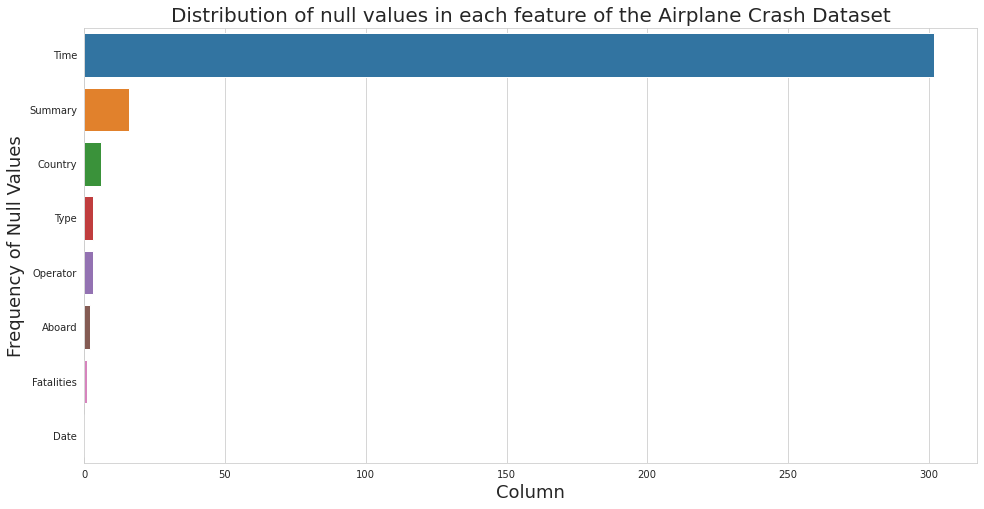

In [18]:
display_basic_data_info(airplane_crashes)

`Fatalities` has one missing value. We found the actual values for [795]('https://aviation-safety.net/database/record.php?id=20000322-0') and imputed them.

In [19]:
airplane_crashes[airplane_crashes['Fatalities'].isnull()]

,Date,Time,Operator,Type,Aboard,Fatalities,Summary,Country
795,03/22/2000,NaN,Military - Ejército del Aire,CASA 212-DE Aviocar 200,NaN,NaN,Crashed while attempting to land in poor weather.,Spain


In [20]:
airplane_crashes.loc[795, 'Aboard'] = 7
airplane_crashes.loc[795, 'Fatalities'] = 7

In [21]:
airplane_crashes.loc[795, ]

Date                                                 03/22/2000
Time                                                        NaN
Operator                           Military - Ejército del Aire
Type                                    CASA 212-DE Aviocar 200
Aboard                                                        7
Fatalities                                                    7
Summary       Crashed while attempting to land in poor weather.
Country                                                   Spain
Name: 795, dtype: object

`Operator` has 3 missing values. We researched the actual Operator for index [615]('https://bst-tsb.gc.ca/eng/rapports-reports/aviation/1997/a97c0215/a97c0215.html'), [692]('https://www.baaa-acro.com/aircraft/rockwell-shrike-commander-500s') and imputed those values. We could not find the correct operator and type for 692 so we dropped it.

In [22]:
airplane_crashes[airplane_crashes['Operator'].isnull()]

,Date,Time,Operator,Type,Aboard,Fatalities,Summary,Country
615,10/30/1997,NaN,NaN,Cessna 206 Seneca,6.0,3.0,Crashed while en route. The pilot continued fl...,Canada
692,11/27/1998,NaN,NaN,NaN,6.0,4.0,Windshear or strong crosswinds caused the airc...,Australia
1230,03/14/2007,NaN,NaN,Rockwell 500S Shrike Commander,4.0,4.0,Fifteen minutes before arriving at its destina...,Brazil


In [23]:
airplane_crashes.loc[615, 'Operator'] = 'Fort McMurray Flight Service Station'
airplane_crashes.loc[1230, 'Operator'] = 'BATA'
airplane_crashes.drop(692, inplace=True)

`Type` has 2 null values. We found the actual type for [1184]('http://www.an2flyers.org/accidents.html'), but not for 489, so we imputed 1184 and dropped 489.

In [24]:
airplane_crashes[airplane_crashes['Type'].isnull()]

,Date,Time,Operator,Type,Aboard,Fatalities,Summary,Country
489,02/11/1996,NaN,Military - Taliban Militia,NaN,20.0,20.0,The helicopter was shot down.,Afghanistan
1184,04/23/2006,20:50,Yug Avia,NaN,5.0,4.0,"Shortly after takeoff, the pilot made sharp ma...",Russia


In [25]:
airplane_crashes.drop(489, inplace=True)
airplane_crashes.loc[1184, 'Type'] = 'Antonov An-2'

We did the same for `Country` for index [124]('https://aviation-safaety.net/database/record.php?id=20060416-0'), [133]('https://en.wikipedia.org/wiki/Lockheed_L-100_Hercules'), [1065]('https://aviation-safety.net/database/record.php?id=20040304-0'), [1289]('https://www.flightglobal.com/ukraine-sees-two-fatal-mil-mi-8-helicopter-crashes-in-a-month/80095.article')

We dropped row [170]('https://en.wikipedia.org/wiki/Aerol%C3%ADneas_Argentinas_Flight_386') because it was not a plane crash. One person died from eating food contaminated with cholera. We dropped row [1129]('https://en.wikipedia.org/wiki/CASA_C-212_Aviocar#Incidents_and_accidents') because we could not find the correct country.

In [26]:
airplane_crashes[airplane_crashes['Country'].isnull()]

,Date,Time,Operator,Type,Aboard,Fatalities,Summary,Country
124,08/15/1991,NaN,Transports Aériens de la Guinee-Bissau,Fokker F-27 Friendship 100,3.0,3.0,On a positioning flight the plane struck trees...,NaN
133,09/17/1991,NaN,Ethiopian Airlines,Lockheed L-100-30 Hercules,4.0,4.0,After experiencing a nose gear problem and att...,NaN
170,02/20/1992,NaN,Aerolineas Argentinas,Boeing B-747,NaN,1.0,A passenger died of cholera while en route.,NaN
1065,03/04/2004,09:40,Azov Avia Airlines,Ilyushin II-76,7.0,3.0,Shortly after taking off and climbing to about...,NaN
1129,02/22/2005,07:15,Indonesian National Police,CASA 212 Aviocar,18.0,15.0,"On final approach, the aircraft crashed into t...",NaN
1289,04/28/2008,09:38,Naftogaz,Mil Mi-8T,20.0,20.0,The helicopter crashed after the tail section ...,NaN


In [27]:
airplane_crashes.loc[124, 'Country'] = 'Bolivia'
airplane_crashes.loc[133, 'Country'] = 'Djibouti'
airplane_crashes.drop(170, inplace=True)
airplane_crashes.loc[1065, 'Country'] = 'Afghanistan'
airplane_crashes.drop(1129, inplace=True)
airplane_crashes.loc[1289, 'Country'] = 'Ukraine'

Shape of dataframe is (1354, 8)
Here are the number of null values in each column


,Number of null values
Time,299
Summary,16
Country,0
Fatalities,0
Aboard,0
Type,0
Operator,0
Date,0


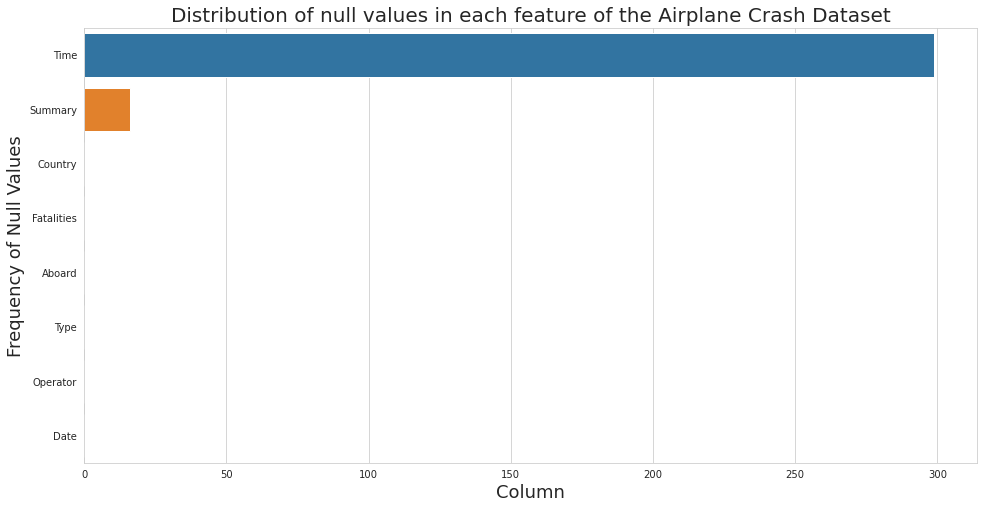

In [28]:
display_basic_data_info(airplane_crashes)

Since time and summary are part of our analysis and we cannot infer anything from the null values currently we will drop the null values

In [29]:
airplane_crashes.dropna(subset=['Time', 'Summary'], inplace = True)

With this we now no longer have any null values

In [30]:
print(f"Shape of dataframe is {airplane_crashes.shape}")
print(f"Here are the number of null values in each column")
# Get's number of null values per column
columnar_null_info = airplane_crashes.isnull().sum().sort_values(ascending = False)
columnar_null_info = columnar_null_info.to_frame() #Converts to dataframe
columnar_null_info.columns = ['Number of null values']
display(columnar_null_info) #Displays the dataframe

Shape of dataframe is (1050, 8)
Here are the number of null values in each column


,Number of null values
Country,0
Summary,0
Fatalities,0
Aboard,0
Type,0
Operator,0
Time,0
Date,0


In [31]:
airplane_crashes.to_csv('airplane_crashes_clean.csv', index=False)

# Data Analysis & Results

# EDA

# Structure

## Airplane Crash Dataset

### Format: 
The dataset comes in a basic ".csv" format. There is no special preprocessing needed to read in the file. Pandas .read_csv() function works for loading in the raw data 

### Separation of Observations:
In our Airplane Crash dataset each row represents a single observation. Specifically the observation contains information of 1 airplane crash. We do not need to do any unnesting of rows to read in the data

### Features/Variables
Using the data dictionary from Kaggle we have:
- Date: Date of accident, in the format - January 01, 2001
- Time: Local time, in 24 hr. format unless otherwise specified
- Location: Location of the accident
- Operator: Airline or operator of the aircraft
- Flight #: Flight number assigned by the aircraft operator
- Route: Complete or partial route flown prior to the accident
- Type: Aircraft type
- Registration: ICAO registration of the aircraft
- cn/In: Construction or serial number / Line or fuselage number
- Aboard: Total aboard (passengers / crew)
- Summary: A summary of the accident if available

Out of these the only features we use for our analysis are Date, Time, Location, Operator, Type, Aboard, Summary and Fatalities. Additionally we use Route and Summary in the cleaning of the dataset

## Nominal GDP Per Capita Dataset

### Format: 
The dataset comes in a tabular format on Wikipedia. We need to use webscraping to load in the data. Specifically iterate through the **td** tags of the relevant table and load in the information one by one 

### Separation of Observations:
Each row is an observation again. It contains the name of a country and the nominal GDP. We do not need to do any annesting of rows to read in the data due to the iterative manner in which we load

### Features/Variables
Using the information in the Wikipedia page:
- Country/Territory: Country name
- USD: Stating the Nominal GDP per capita of that nation in 2019 using USD

We use both features in this analysis. The Country is cleaned slightly to be more human readable formats (Rearranging to place the , after the first word for most countries)

## US States Dataset

### Format: 
The dataset comes in a tabular format on Wikipedia. We need to use webscraping to load in the data. Specifically iterate through the **td** tags of the relevant table and load in the information one by one 

### Separation of Observations:
Each row is an observation again. It has several information regarding features of each state in US. We do not need to do any annesting of rows to read in the data due to the iterative manner in which we load

### Features/Variables
Using the information in the Wikipedia page:
- Flag, Name and Postal Abbreviation: The flag of the state comes in a picture, the name is in full form and the 2 letter abbreviation of the state
- Cities: Capital and Largest cities of each of the states
- Ratification or admission: When was the state ratified/officially recognized
- Population: As of 2019
- Total Area: Total area of state in both square miles and square kilometers
- Land Area: Land area of state in both square miles and square kilometers
- Water Area: Water area of state in both squares miles and square kilometers
- Number of reps: Number of representatives in that state: In the current decade

Despite the large amount of information present in this dataset we will only be using the state names. This dataset is only used in cleaning and not in the analysis portion of our work

## Join

Each table is complete on it's own. For the sake of analysis we will need to join the information about nominal GDP to the Airplane Crash dataset. The States dataset is used for cleaning purposes and no other information is read in. For joining the Nominal GDP and Airplane Crash dataset we have to clean up the Countries in our Airplane crash dataset so we don't lose too much information (human errors in spelling and formatting). We will then execute an inner merge as countries without GDP information can't be used in our analysis. We will merge on the country names and use the method df.merge to merge the 2 dataframes on the given column

# Granularity

## Airplane Crash Dataset

Our airplane crash dataset has individual level granularity in terms of crashes. It groups several people's stats as a number (like number of people aboard) but we still treat this as an individual level granularity due to our analysis focusing on each individual crash and the likelihood of crashes given factors. All the rows are uniform in that they all talk about a crash and don't randomly summarize or desummarize pieces of information

## Nominal GDP Dataset

Our nominal GDP dataset has group level granularity in terms of each country. It groups several people's stats as a number (like individual GDP of people). All the rows are uniform in that they all talk about a country's GDP and don't randomly summarize or desummarize pieces of information. The data is aggregated into nominal GDP in USD which comes from total private consumption, gross investment, government investment, spending, exports, imports etc. It is not adjusted for inflation. We don't plan on deaggregating it since we want information on each country as a whole

## States Dataset

Our state names dataset has group level granularity in terms of states. All the rows are uniform in that they tall talk about a state's features such as land area and number of reps. The data of land area is aggregated by summarizing the city and county information. We will not deaggregate this since we want to use the state names here

# Scope

In [32]:
raw_df = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
clean_df = pd.read_csv('airplane_crashes_clean.csv')
clean_df['Date'] = pd.to_datetime(clean_df['Date'])

### Descriptive Statistics

In [33]:
raw_df.describe()

,Aboard,Fatalities,Ground
count,5246.000000,5256.000000,5246.000000
mean,27.554518,20.068303,1.608845
std,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000
50%,13.000000,9.000000,0.000000
75%,30.000000,23.000000,0.000000
max,644.000000,583.000000,2750.000000


In [34]:
clean_df.describe()

,Aboard,Fatalities
count,1050.000000,1050.0000
mean,33.132381,22.3800
std,56.175442,41.0852
min,1.000000,0.0000
25%,4.000000,3.0000
50%,10.000000,7.0000
75%,30.000000,19.0000
max,517.000000,349.0000


### Count of Missing Values in Each Column

Initially our dataset's null value distribution was as follows

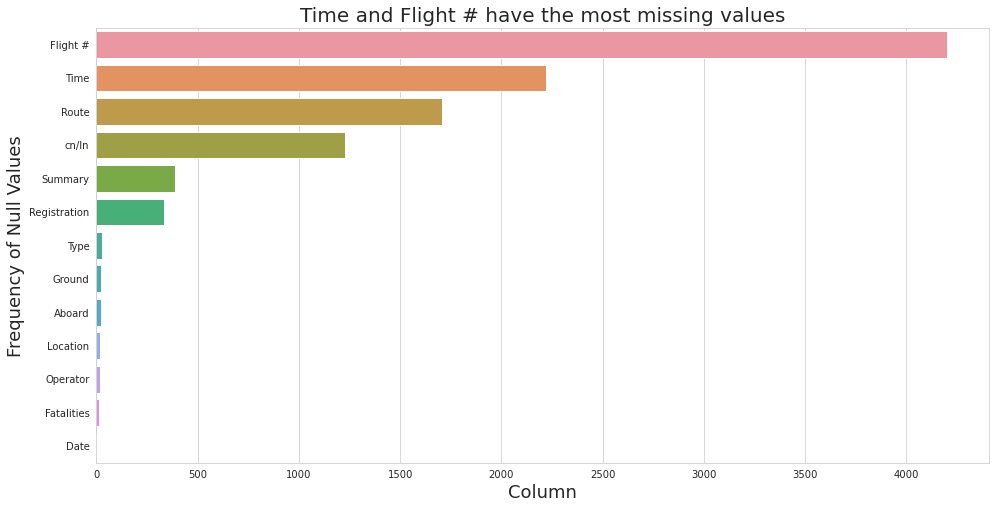

In [35]:
missing = raw_df.isnull().sum(axis=0).sort_values(ascending = False)

_, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=missing.values, y=missing.index, ax=ax);
ax.set_title('Time and Flight # have the most missing values', fontsize=20);
ax.set_xlabel('Column', fontsize=18);
ax.set_ylabel('Frequency of Null Values', fontsize=18);

After cleaning using the data cleaning steps above we have

In [36]:
missing = clean_df.isnull().sum(axis=0).sort_values(ascending = False)
missing = missing.to_frame()
missing.columns = ['Number of null values']
display(missing)
print(f"Shape of dataframe is {clean_df.shape}")

,Number of null values
Country,0
Summary,0
Fatalities,0
Aboard,0
Type,0
Operator,0
Time,0
Date,0


Shape of dataframe is (1050, 8)


We now have no missing data with over 1000 rows still remaining for analysis. This does introduce bias which we will make sure we cover during our analysis

### Distribution of Feature Variables

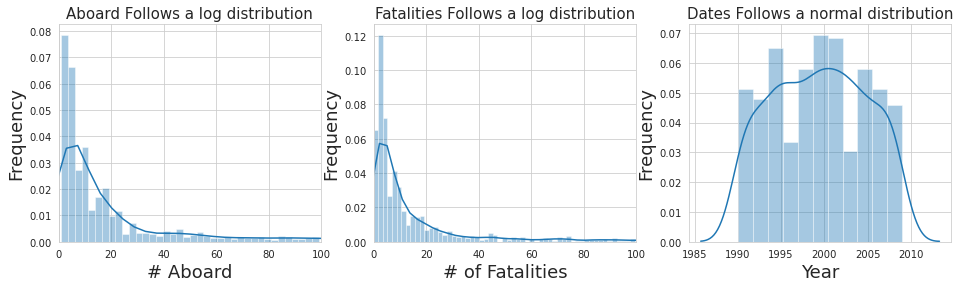

In [37]:
_, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.distplot(clean_df.Aboard, ax=ax[0], bins=200);
ax[0].set_title('Aboard Follows a log distribution', fontsize=15);
ax[0].set_xlabel('# Aboard', fontsize=18);
ax[0].set_ylabel('Frequency', fontsize=18);
ax[0].set_xlim(0,100);

sns.distplot(clean_df.Fatalities, ax=ax[1], bins=200);
ax[1].set_title('Fatalities Follows a log distribution', fontsize=15);
ax[1].set_xlabel('# of Fatalities', fontsize=18);
ax[1].set_ylabel('Frequency', fontsize=18);
ax[1].set_xlim(0,100);

sns.distplot(clean_df.Date.dt.year, ax=ax[2]);
ax[2].set_title('Dates Follows a normal distribution', fontsize=15);
ax[2].set_xlabel('Year', fontsize=18);
ax[2].set_ylabel('Frequency', fontsize=18);

Through these plots above we can see that Aboard and Fatalities follow a log distribution while Dates has a normal distribution with a touch of trimodality. We do not expect this to be an issue since CLT nearly guarantees a normal distribution of statistics irrespective of the original distribution of the data as long as we have at least a certain number of samples (Usually 30-60). We have 1000 and we don't expect this to be an issue but we will tread with caution

### Relationship Between All Variables

Text(0.5, 1.05, 'Relation between Aboard and Fatalities')

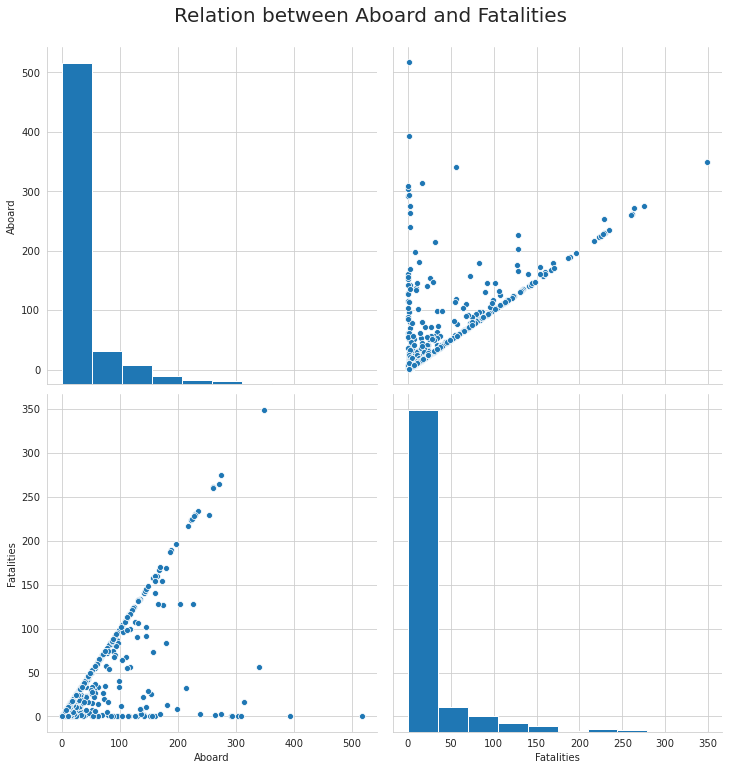

In [38]:
relationship_fig = sns.pairplot(clean_df, height=5, palette='bright') 
relationship_fig.fig.suptitle("Relation between Aboard and Fatalities", fontsize=20, y = 1.05)

We can see that aboard and fatalities do not have any homoskedacity. Fatalities and aboard once again show a strong right skew. We can also see no multicolinearity in our dataset. Nevertheless this does indicate that a linear regression based analysis would not be appropriate here despite there being a noticeable line

# Temporality 


Let's see how many rows are outside of the 24 hour range in the `Time` column.

In [39]:
def convert_strtime_to_hour(time):
    if pd.isnull(time):
        return time
    else: 
        time = time.replace("'", ':').replace('c: ', '')
        time = datetime.strptime(str(time), '%H:%M')
        if time.hour >= 0 and time.hour <= 24:
            return True
        else:
            return False

In [40]:
print('The number of rows in which the hour is outside the 24 hrs range is: ' + str((airplane_crashes.Time.apply(convert_strtime_to_hour) == False).sum()))


The number of rows in which the hour is outside the 24 hrs range is: 0


We will do the same thing for the `Date` column with month, day, and year, respectively.

In [41]:
def convert_strtime_to_month(time):
    if time.month >= 1 and time.month <= 12:
        return True
    else:
        return False
        
def convert_strtime_to_day(time):
    if time.day >= 1 and time.day <= 31:
        return True
    else:
        return False
        
def convert_strtime_to_year(time):
    if time.year >= 1990 and time.year <= 2010:
        return True
    else:
        return False

In [42]:
print('The number of rows in which the year is outside the range 1990-2010 is: ' + str((pd.to_datetime(airplane_crashes.Date).apply(convert_strtime_to_year) == False).sum()))
print('The number of rows in which the month is outside the range 1-12 is: ' + str((pd.to_datetime(airplane_crashes.Date).apply(convert_strtime_to_month) == False).sum()))
print('The number of rows in which the day is outside the range 1-31 is: ' + str((pd.to_datetime(airplane_crashes.Date).apply(convert_strtime_to_day) == False).sum()))


The number of rows in which the year is outside the range 1990-2010 is: 0
The number of rows in which the month is outside the range 1-12 is: 0
The number of rows in which the day is outside the range 1-31 is: 0


For our third research question, we will add a new column to categorize the `Time` column into either day or night. The `Time` column is in local timezone. The way we categorize these two daylight conditions is anytime between 6am to 6pm will be labeled as `day`, and `night` otherwise.

In [43]:
def convert_to_day_night(time):
    if pd.isnull(time):
        return time
    else: 
        time = time.replace("'", ':').replace('c: ', '')
        time = datetime.strptime(str(time), '%H:%M')
        if time.hour >= 6 and time.hour <= 19:
            return 'Day'
        else:
            return 'Night'
    
airplane_crashes['day_night'] = airplane_crashes.Time.apply(convert_to_day_night)
airplane_crashes

,Date,Time,Operator,Type,Aboard,Fatalities,Summary,Country,day_night
1,02/05/1990,08:37,Helicopteros Nacionales de Colombia,Grumman G-159 Gulfstream I,15.0,15.0,"Struck Mt. El Saluda at 5,000 ft., near Image,...",Colombia,Day
2,01/02/1990,13:40,Pelita Air Service,CASA 212 Aviocar 200,16.0,9.0,Ditched into the Java Sea after experiencing m...,Indonesia,Day
3,01/13/1990,12:56,Aeroflot,Tupolev TU-134A,71.0,27.0,A fire in the rear cargo hold and fire warning...,Russia,Day
4,01/15/1990,08:30,SANSA,CASA 212 Aviocar 200,23.0,23.0,"Crashed about 4,500 feet up on 7,250 ft. Pico ...",Costa Rica,Day
5,01/17/1990,07:19,Federal Express,Cessna 208A Caravan I Cargomaster,1.0,1.0,"The cargo plane crashed into a 14,200 ft. Moun...",United States,Day
...,...,...,...,...,...,...,...,...,...
1351,04/29/2009,06:00,Bako Air,Boeing B-737-200,7.0,7.0,Crashed while en route on a ferrying flight. T...,Democratic Republic of the Congo,Day
1352,05/03/2009,12:00,Military - Venezuelan Army,Mi-35,18.0,18.0,The helicopter was patrolling along the Venezu...,Venezuela,Day
1353,05/20/2009,06:30,Military - Indonesian Air Force,Lockheed C-130 Hercules,112.0,98.0,"While on approach, the military transport cras...",Indonesia,Day
1355,06/01/2009,00:15,Air France,Airbus A330-203,228.0,228.0,The Airbus went missing over the AtlantiOcean ...,Brazil,Night


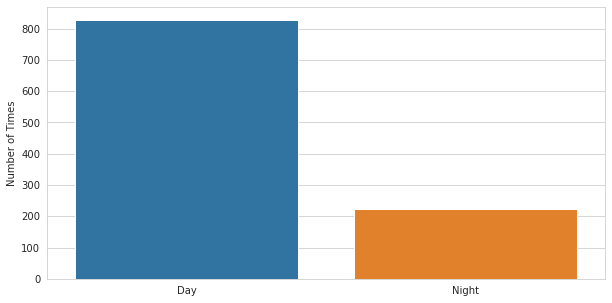

In [44]:
day_night_vc = airplane_crashes.day_night.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = day_night_vc.index, y = day_night_vc.values).set(ylabel='Number of Times')
plt.show()


Airplane accidents recorded in this dataset happen much more frequently during day than during night. This indicates that based on this dataset from 1990-2009, airplane accidents are much more likely to happen during daytime. One thing to note is that we have previously dropped 299 null values in `Time`, about 1/5 of the entire dataset. Thus, this large difference may be skewed in one way or another if we were to have complete information about the time at which the accident occurred. Still, we will still take into consideration the current result, since even if a majority of the 299 null values actually occurred nightime, that would still put accidents in daytime to be more frequent.

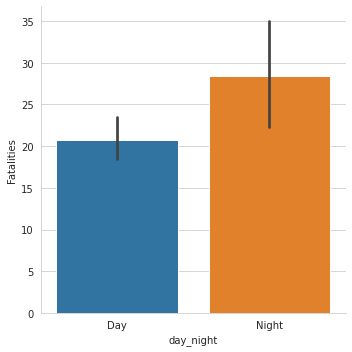

In [45]:
sns.catplot(x = 'day_night', y = 'Fatalities', kind="bar", data=airplane_crashes)

Interstingly, although the number of accidents that occurred during daytime is much higher than that of nightime, the number of fatalities during nightime on average is higher than that of the daytime. This may indicate that while nightime accidents occurr less frequently, when they do occurr, the severity of the accident will be greater than that of daytime accidents on average.

Next, we will group each individual year into each of the 4 year intervals, 1990-1994, 1995-1999, 2000-2004, 2005-2009, respectively. This way, it is easier to see how the daylight conditions affect the number of fatalities grouped by each of these 4 year intervals. 

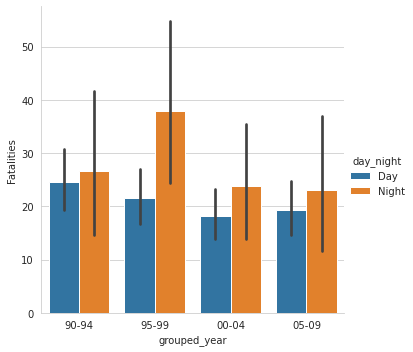

In [46]:
def condense_year(datetime):
    if datetime.year >= 1990 and datetime.year <= 1994:
        return '90-94'
    elif datetime.year >= 1995 and datetime.year <= 1999:
        return '95-99'
    elif datetime.year >= 2000 and datetime.year <= 2004:
        return '00-04'
    elif datetime.year >= 2005 and datetime.year <= 2009:
        return '05-09'
    
airplane_crashes['grouped_year'] = pd.to_datetime(airplane_crashes['Date']).apply(condense_year)
sns.catplot(x = 'grouped_year', y = 'Fatalities', kind="bar", hue="day_night", data=airplane_crashes)

For all 4 year intervals, airplane accidents that happen during night have higher number of fatalities, and is especially the case during 1995-1999.

# Faithfulness

We first convert the `Date` column into datetime format.

In [47]:
airplane_crashes = clean_df.copy()

In [48]:
airplane_crashes.Date = pd.to_datetime(airplane_crashes.Date)

In [49]:
sns.set(style="whitegrid", font_scale=2)

While we do not know whether the data was entered by hand, we will perform some checks on the variables to determine how faithful they are. After our data cleaning steps, we have no null values

### Airplane Crashes: Numeric Columns

In [50]:
airplane_crashes['Date'].min()

Timestamp('1990-01-02 00:00:00')

In [51]:
airplane_crashes['Date'].max()

Timestamp('2009-06-07 00:00:00')

There are no unreasonable dates. Our research question looks at the last 30 years of the dataset, which is from 1990-2010. We'll add a year column to have a better understanding of the distribution of the time column.

In [52]:
airplane_crashes['Year'] = airplane_crashes.Date.apply(lambda x: x.year)

In [53]:
airplane_crashes.describe()

,Aboard,Fatalities,Year
count,1050.000000,1050.0000,1050.000000
mean,33.132381,22.3800,1999.383810
std,56.175442,41.0852,5.423207
min,1.000000,0.0000,1990.000000
25%,4.000000,3.0000,1995.000000
50%,10.000000,7.0000,1999.000000
75%,30.000000,19.0000,2004.000000
max,517.000000,349.0000,2009.000000


There is  nothing unusual about the year of these airplane crashes because the min and max are within the scope of our question. The number aboard and fatalities are centered with a median or 10 and 7, respectively. These values are both lower than the means, which indicates that we have some extreme values.

Aboard and Fatalities have a high standard deviation, which is reasonable because the passengers aboard depend on the varying sizes of the aircrafts and the fatalities range depending on how catastrophic the crash was. 

The min is reasonable because there is always at least one person aboard and not all crashes have fatalities. The max is something that we will investigate later because they are extreme values. 

We plotted the distributions earlier in the report. The distributions of both aboard and fatalities are skewed to the right, so we will see if there are any unreasonable values in these outliers. Most of the values are closer to 0. The years are more evenly distributed in comparison, although there are more instances of airplane crashes before the year 2000. 

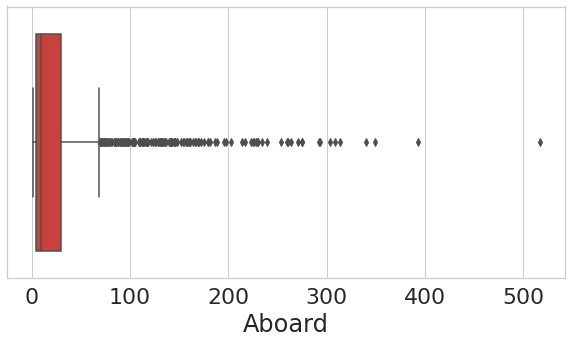

In [54]:
plt.figure(figsize=(10, 5))
sns.boxplot(airplane_crashes['Aboard'], color='#DE2D26');

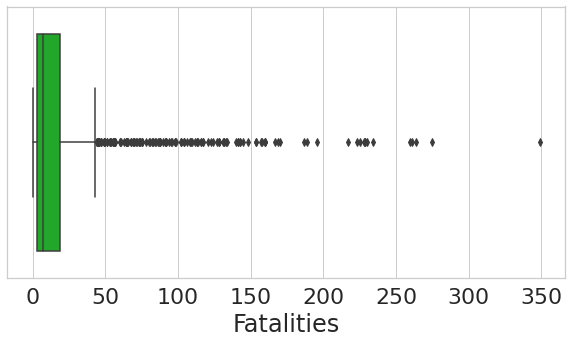

In [55]:
plt.figure(figsize=(10, 5))
sns.boxplot(airplane_crashes['Fatalities'], color='#0CBD18');

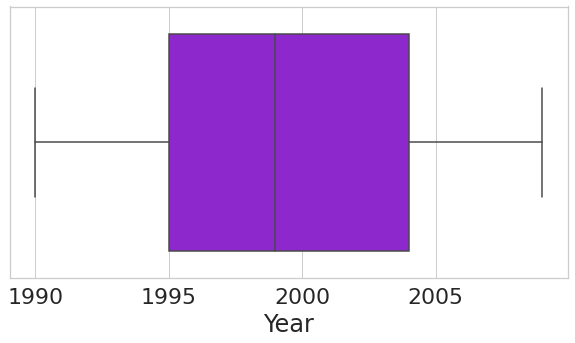

In [56]:
plt.figure(figsize=(10, 5))
sns.boxplot(airplane_crashes['Year'], color='#940CE8');

There are no outliers for year. We have a wide range of values for aboard and fatalities, which is reasonable because a transport plane wouldn't have as many passengers as a large commercial plane. Even though the individual points are marked as outliers, the outliers that we want to check are the >350 aboard and >300 fatalities.

In [57]:
airplane_crashes[airplane_crashes['Aboard']>350]

,Date,Time,Operator,Type,Aboard,Fatalities,Summary,Country,Year
406,1997-12-28,23:10,United Air Lines,Boeing B-747-122,393.0,1.0,"Two hours into the flight, at FL 310, the plan...",Japan,1997
494,1999-07-23,11:25,All Nippon Airways,Boeing B-747,517.0,1.0,Two minutes after taking off from Haneda Airpo...,Japan,1999


[626](https://aviation-safety.net/database/record.php?id=19971228-0) and [735](https://en.wikipedia.org/wiki/All_Nippon_Airways_Flight_61) have been validated by our Internet research, they are true.

In [58]:
airplane_crashes[airplane_crashes['Fatalities']>300]

,Date,Time,Operator,Type,Aboard,Fatalities,Summary,Country,Year
346,1996-11-12,18:40,Saudi Arabian Airlines / Kazastan Airlines,Boeing B-747-168B / Ilyushin IL-76TD,349.0,349.0,Midair collision 17 km W of New Delhi. The Sa...,India,1996


[545](https://en.wikipedia.org/wiki/1996_Charkhi_Dadri_mid-air_collision) have been validated by our Internet research, they are true.

In [59]:
(airplane_crashes['Aboard'] < airplane_crashes['Fatalities']).sum()

0

We cannot have more passenger fatalities than are there passengers aboard, so we will test the faithfulness of this data. There are no instances where the number of fatalities is greater than the number of passengers aboard, which shows that these two variables have reasonable values.

### Airplane Crashes: Categorical Columns

In [60]:
airplane_crashes['Operator'].value_counts()

Private                           14
Military - U.S. Air Force         11
Aeroflot                           8
American Airlines                  6
Military - Sri Lanka Air Force     6
                                  ..
Military - Argentine Air Force     1
Perimeter Airlines                 1
Bako Air                           1
SL Aviation Services               1
Asiana Airlines                    1
Name: Operator, Length: 859, dtype: int64

In [61]:
airplane_crashes['Operator'].value_counts()[airplane_crashes['Operator'].value_counts()==1]

MATS - Manila Aero Transport System    1
Military - Zambia Air Force            1
Eastern Air Lines                      1
Military - Government of Macedonia     1
Blue Bird Aviation                     1
                                      ..
Military - Argentine Air Force         1
Perimeter Airlines                     1
Bako Air                               1
SL Aviation Services                   1
Asiana Airlines                        1
Name: Operator, Length: 748, dtype: int64

In [62]:
airplane_crashes['Type'].value_counts()

de Havilland Canada DHC-6 Twin Otter 300    28
Cessna 208B Grand Caravan                   15
Cessna 208B Caravan I Super Cargomaster     13
Yakovlev YAK-40                             12
Antonov AN-26                                9
                                            ..
Boeing B-767-3Z9ER                           1
CASA CN-235M-10                              1
Aerospatiale 350B1                           1
Cessna 210                                   1
Bell 407 / Bell 407                          1
Name: Type, Length: 702, dtype: int64

In [63]:
airplane_crashes['Type'].value_counts()[airplane_crashes['Type'].value_counts()==1]

Cessna 177B Cardinal          1
Airbus A320-231               1
Boeing B-737-3Y0              1
Grumman G73T Turbo Mallard    1
Mil Mi-18 Helicopter          1
                             ..
Boeing B-767-3Z9ER            1
CASA CN-235M-10               1
Aerospatiale 350B1            1
Cessna 210                    1
Bell 407 / Bell 407           1
Name: Type, Length: 558, dtype: int64

Out of the 1054 unique operators, 897 of them each occur once in our data. Out of the 837 unique types, 646 of them occur once in our data. If we were looking at correlations with these variables we would need to be careful to choose ones that have multiple occurences in the data or have a balanced sample where each category is well represented.

In [64]:
airplane_crashes['Country'].value_counts()

United States    292
Russia            52
Canada            45
Brazil            36
Colombia          34
                ... 
Iceland            1
Suriname           1
Vanuatu            1
Morocco            1
Belgium            1
Name: Country, Length: 134, dtype: int64

In [65]:
airplane_crashes['Country'].value_counts()[airplane_crashes['Country'].value_counts()==1].size

41

In [66]:
airplane_crashes['Country'].unique()

array(['Colombia', 'Indonesia', 'Russia', 'Costa Rica', 'United States',
       'Venezuela', 'Republic of the Congo', 'Brazil', 'India', 'Zambia',
       'Afghanistan', 'Norway', 'Philippines', 'Canada', 'Guatemala',
       'Mexico', 'United Kingdom', 'Germany', 'China', 'Bolivia', 'Cuba',
       'Switzerland', 'Thailand', 'Chile', 'Uzbekistan', 'Belize',
       'French Polynesia', 'The Bahamas', 'Angola', 'Nigeria',
       'Saudi Arabia', 'Mozambique', 'Sweden', 'France', 'Azerbaijan',
       'Senegal', 'Greece', 'Puerto Rico', 'Australia', 'Sri Lanka',
       'Nepal', 'Netherlands', 'Vietnam', 'Portugal', 'Libya', 'Iran',
       'North Macedonia', 'The Gambia', 'South Korea', 'Tajikistan',
       'Poland', 'Laos', 'Armenia', 'Iraq', 'Japan', 'Africa',
       'Mauritania', 'Algeria', 'Hong Kong', 'Papua New Guinea', 'Turkey',
       'New Zealand', 'Romania', 'Ecuador', 'Dominican Republic',
       'El Salvador', 'Malaysia', 'Mongolia', 'Argentina', 'Cameroon',
       'Haiti', 'Italy',

We have cleaned the countries in our data cleaning process. Upon looking at the unique country values, they are all valid countries. 45 of the 148 unique countries only have one occurence. The distribution is not balanced (there are significantly more instances of the United States) so we would need to make sure that in our analysis that the countries are balanced.

### GDP Data

In [67]:
gdp_data.describe()

,Nominal GDP Per Capita in US Dollars
count,217.000000
mean,17617.119816
std,26881.025933
min,105.000000
25%,2203.000000
50%,6674.000000
75%,21603.000000
max,190532.000000


There is a known disparity in GDP for countries because some countries are significantly more well off than others, so the standard deviation and min/max are not extremely concerning. There are no negative values present, which is good because we cannot have a negative nominal GDP. But we will still take a look at the outliers.

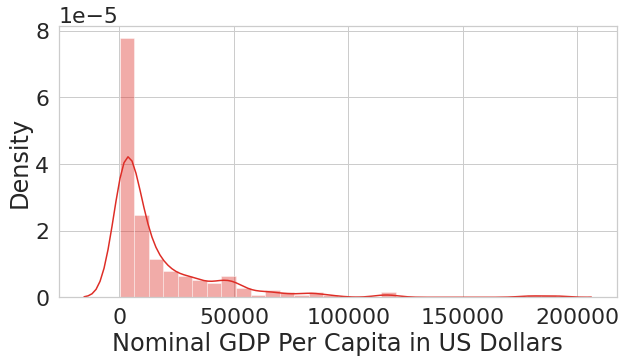

In [68]:
plt.figure(figsize=(10,5))
sns.distplot(gdp_data['Nominal GDP Per Capita in US Dollars'], color='#DE2D26')\
.set(ylabel='Density')
plt.show()

The distribution is skewed to the right, suggesting that most countries have a modest GDP, while very few have a high GDP.

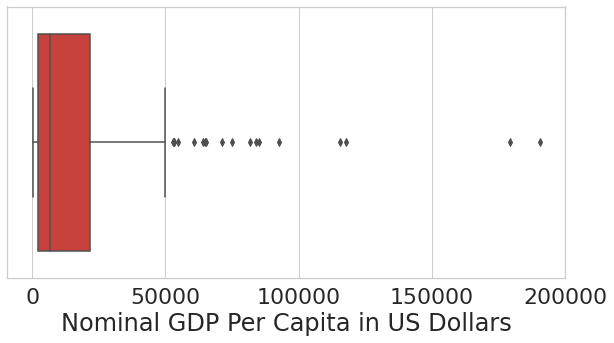

In [69]:
plt.figure(figsize=(10,5))
sns.boxplot(gdp_data['Nominal GDP Per Capita in US Dollars'], color='#DE2D26')
plt.show()

This supports the suggestion that most countries have a modest GDP below 50,000, and there are a few countries that are considered outliers. We wanted to investigate the 4 most extreme outliers because they are the furthest away from the distribution.

In [70]:
gdp_data[gdp_data['Nominal GDP Per Capita in US Dollars'] > 100000]

,Country,Nominal GDP Per Capita in US Dollars
0,Monaco,190532
1,Liechtenstein,179258
2,Luxembourg,115481
3,Bermuda,117768


In [71]:
gdp_data[gdp_data['Nominal GDP Per Capita in US Dollars'] < 200]

,Country,Nominal GDP Per Capita in US Dollars
216,Somalia,105


These are the lower and upper extreme values of the GDP. But they are reasonably extreme because some countries are significantly wealthy (especially these 4) and some are significantly less wealthy (Somalia being one of them). We validated in Wikipedia that these are indeed the correct nominal GDP values.

In [72]:
gdp_data.Country.nunique() == len(gdp_data.Country)

True

Every country has its own unique nominal GDP. There are no countries that have multiple GDP's.

In [73]:
all(i in gdp_data['Country'].to_list() for i in airplane_crashes['Country'].to_list())

True

All the countries in our airplane crashes dataset have an associated gdp in our gdp dataset.

Overall in the gdp and airplane crash dataset, we have reasonable values, no inconsistencies aross tables, and no reason to believe that there is any falsification involved. Although we do not fully know how the data was generated, we will, with caution, continue investigating because our findings show that the data is reasonable.

# Data Analysis

## What are the major factors noticed during crashes?

To explore the major groups/categories noticeable in our crash dataset let's first make a copy of our cleaned dataframe to make changes

In [74]:
summary_analysis_data = airplane_crashes.copy() #Creating a copy of the cleaned dataframe

Before analyzing the summaries for analysis we need to do some preprocessing to remove stop words. We use the WordNetLemmatizer and SnowballStemmer to group similar words into 1. This will increase the effectiveness of our analysis. Finally we use our domain knowledge to drop some commonly visible tokens that will be present throughout the summary

In [75]:
def preprocess_summary(summary):
    words = []
    stemmer = SnowballStemmer('english')
    for token in gensim.utils.simple_preprocess(summary):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3: # Removing short tokens and stop words
            if token not in ['plane', 'aircraft', 'flight', 'airport', 'pilot']: # Removing common words that exist in summary
                words.append(stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v'))) # Stemming and Lemmatizing words
    return words

Let's see how this pre processing affects a given summary

In [76]:
first_summary = summary_analysis_data.Summary.values[0]
print(f'Original Summary: {first_summary}') # Printing first summary
print(f"Preprocessed Summary: {' '.join(preprocess_summary(first_summary))}") # Preprocessing a summary

Original Summary: Struck Mt. El Saluda at 5,000 ft., near Image, after announcing a go-around with intentions of diverting to their alternate.
Preprocessed Summary: strike saluda near imag announc intent divert altern


We can see that the preprocessed summary does not make much sense to a human. However, it does capture a lot of the more important unique words in this summary. Let's use this on the entire dataframe

In [77]:
preprocessed_summaries = summary_analysis_data['Summary'].apply(preprocess_summary) # Preprocessing entire datarame
preprocessed_summaries.head()

0    [strike, saluda, near, imag, announc, intent, ...
1    [ditch, java, experi, mechan, problem, right, ...
2    [rear, cargo, hold, warn, engin, forc, crash, ...
3    [crash, feet, pico, blanco, mountain, mile, so...
4    [cargo, crash, mount, massiv, feet, summit, ro...
Name: Summary, dtype: object

Now that we have a Series containing the preprocessed summaries we need to create a Dictionary out of this. A Dictionary is a mapping b/w the words passed and their integer IDs. An example can be seen below

In [78]:
dictionary = gensim.corpora.Dictionary(preprocessed_summaries)
for idx, (k, v) in enumerate(dictionary.iteritems()): # Printing dictionary items
    print(k, v)
    if idx == 5: # Break after 5 have been printed
        break

0 altern
1 announc
2 divert
3 imag
4 intent
5 near


Now that we have our dictionary we need to remove the rare and most common words. We have around 1000 rows in our dataset. We filter the dictionary to remove any word that does not occur in at least 100 of our rows and remove those words that appear in more than 70% of the rows. This allows us to better topic cluster as we will find words that can be potential topics but filter the extremely common ones that would appear in any topic

In [79]:
dictionary.filter_extremes(no_below=100, no_above=0.7)

We will be using a Latent Dirichlet Allocation model to cluster topics. This is an extremely popular probability based topic clustering algorithm. Since it's probability based it does not benefit heavily from the TFIDF weights provided. Hence we will go with a more straightforward Bag of Words approach

Here are the first 5 elements in the BoW for Summary 140


[(6, 4), (12, 1), (17, 2), (19, 2), (20, 1)]

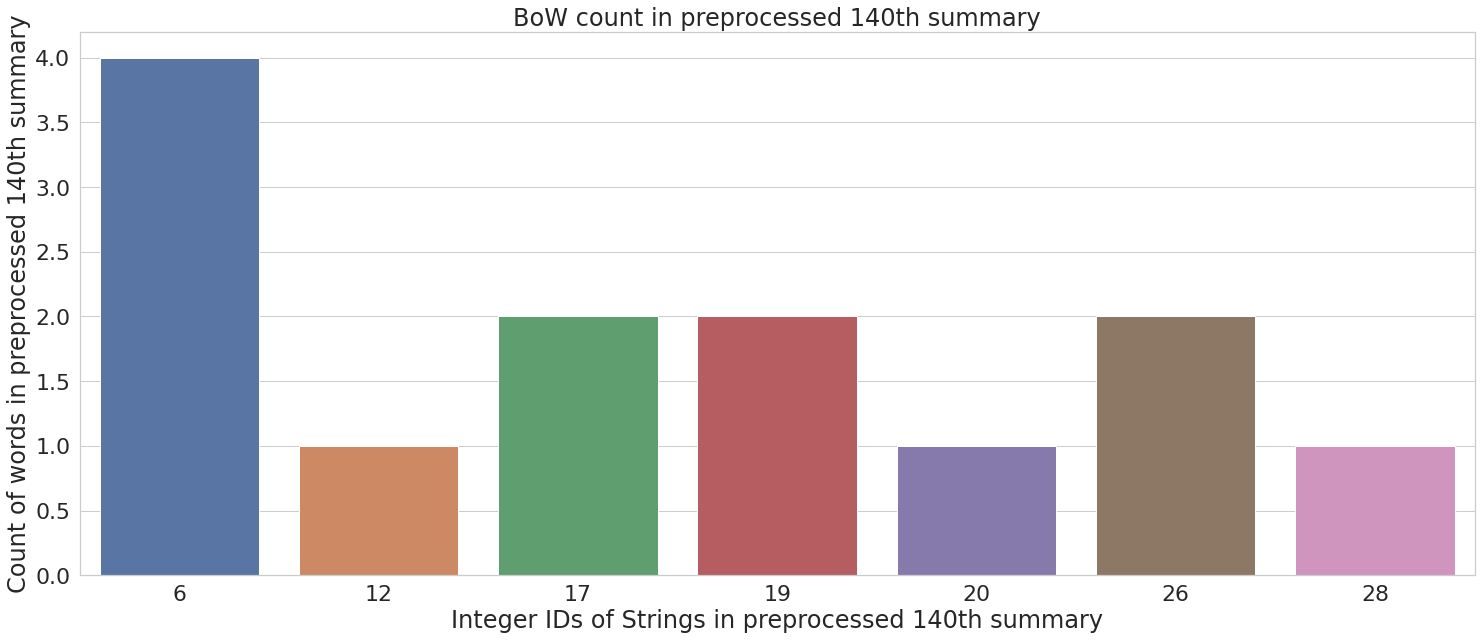

In [80]:
bow = [dictionary.doc2bow(summary) for summary in preprocessed_summaries] # Generating BoW counts
bow_summary_140 = bow[140] #Testing a random one
print("Here are the first 5 elements in the BoW for Summary 140")
display(bow_summary_140[:5])
bow_summary_140_series = pd.DataFrame(bow_summary_140).set_index(0)[1] # Creating Series from it
plt.figure(figsize=(25, 10)) # Plotting barplot
sns.barplot(x=bow_summary_140_series.index, y=bow_summary_140_series.values) 
plt.title("BoW count in preprocessed 140th summary")
plt.ylabel("Count of words in preprocessed 140th summary")
plt.xlabel("Integer IDs of Strings in preprocessed 140th summary")
plt.show()

Each element in the list represents a word and it's count. So in the first bar from the left for example, we see 6 with a height of 4. This means the string with integer ID 6 has a count of 4 in the 140th summary. We can see which word lies in integer ID 6 with the help of the dictionary

In [81]:
dictionary[6]

'land'

We can see it's land. This does make sense since a lot of crash summaries do talk about efforts to land. Let's replot the above bar graph but with better labels

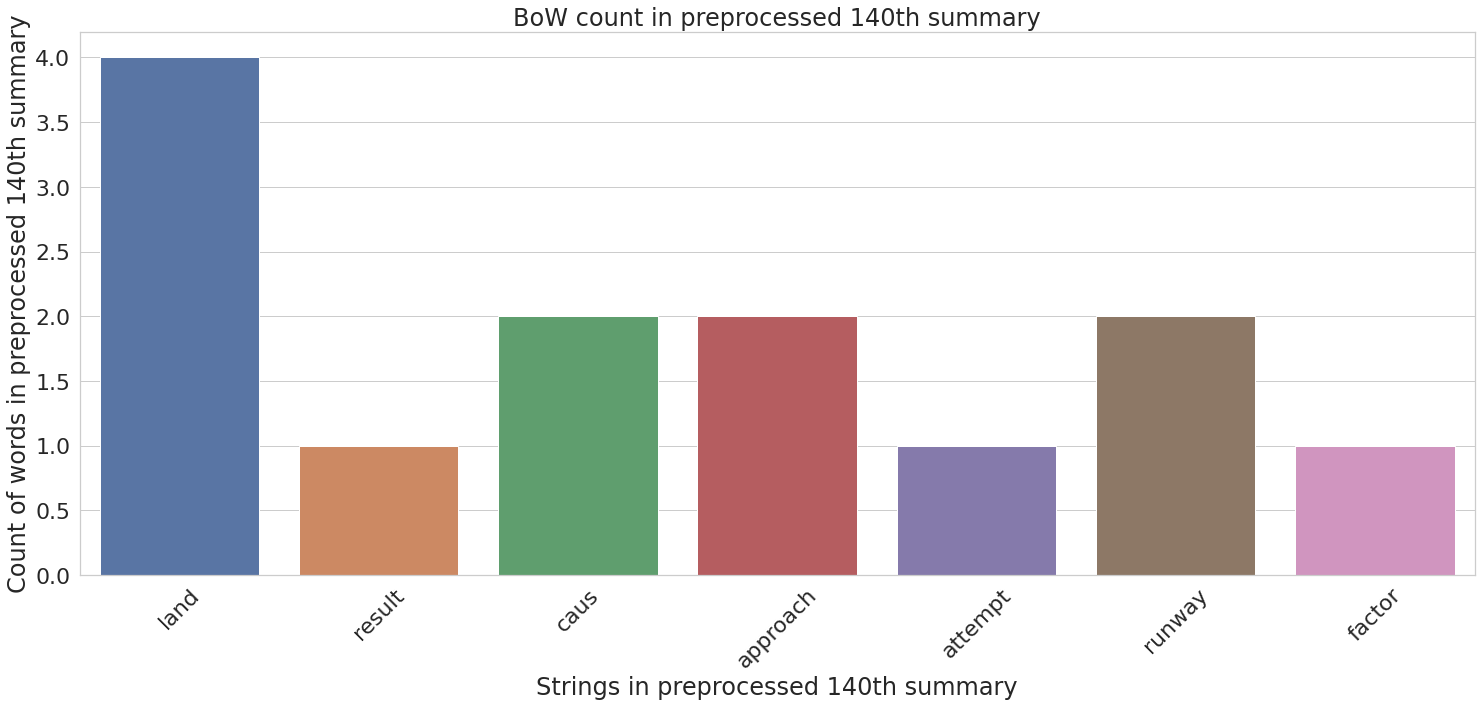

In [82]:
plt.figure(figsize=(25,10))
sns.barplot(x=pd.Series(bow_summary_140_series.index).apply(lambda x: dictionary[x]),y=bow_summary_140_series.values)
plt.title("BoW count in preprocessed 140th summary")
plt.ylabel("Count of words in preprocessed 140th summary")
plt.xlabel("Strings in preprocessed 140th summary")
plt.xticks(rotation=45)
plt.show()

This is much more human readable and now shows the various words stored in our Bag of Words model for a given summary. Let us now fit our Latent Dirichlet Allocation model

In [83]:
# Creating LDA model with the Bow model and Dictionary created earlier
lda_model = gensim.models.LdaMulticore(bow, num_topics=3, id2word=dictionary, passes=2, workers=2)

The reason for choosing only 3 topics will be explained below. The LDA model outputs a 3 element list with the probabilities of whether or not a given summary belongs in Cluster 0, 1 or 2. Let's store this in a matrix

In [84]:
# Storing matrix of predictions
matrix = np.zeros((len(bow),lda_model.num_topics))
for idx, corp in enumerate(bow): # Enumerating through each summary in BoW
    for idx2, pred in enumerate(lda_model[corp]): # Enumerating through predictions from LDA model
        matrix[idx][idx2] = pred[1]
matrix

array([[0.22327295, 0.60360903, 0.173118  ],
       [0.04598108, 0.04701998, 0.90699893],
       [0.86510235, 0.06740752, 0.06749013],
       ...,
       [0.18318656, 0.63863152, 0.17818196],
       [0.07947011, 0.07433233, 0.84619761],
       [0.82547146, 0.08741957, 0.08710895]])

Let us see what's the median probability of belonging to each cluster

In [85]:
np.median(matrix, axis = 0) # Getting the median probability of belonging to a topic

array([0.17670049, 0.1708312 , 0.19008303])

According to the median there is more than a 15% chance of being in a given cluster. This is decent considering it's the median. The mean would be more right tailed. It is also why we stick to 3 clusters. 4 clusters stretches this too low and it falls below 10% while 2 is too high and keeps it at around 50%

Let us now view the rules used in the LDA model to classify

In [86]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nRule: {}'.format(idx, topic)) # Printing rules for each topic

Topic: 0 
Rule: 0.149*"land" + 0.136*"runway" + 0.091*"attempt" + 0.062*"crew" + 0.055*"short" + 0.043*"approach" + 0.041*"mile" + 0.040*"accid" + 0.032*"cargo" + 0.031*"strike"
Topic: 1 
Rule: 0.090*"approach" + 0.071*"weather" + 0.071*"mountain" + 0.067*"take" + 0.059*"grind" + 0.054*"condit" + 0.043*"land" + 0.042*"kill" + 0.041*"crew" + 0.037*"accid"
Topic: 2 
Rule: 0.122*"failur" + 0.089*"engin" + 0.070*"control" + 0.055*"terrain" + 0.051*"crew" + 0.043*"minut" + 0.042*"result" + 0.041*"take" + 0.039*"takeoff" + 0.037*"altitud"


We can see mathematical equations being printed for each and every topic. The LDA model uses these rules and whether or not each word in the rule is present to determine whether or not a summary belongs to a cluster. Let us display these along with other significant words with the help of a word count

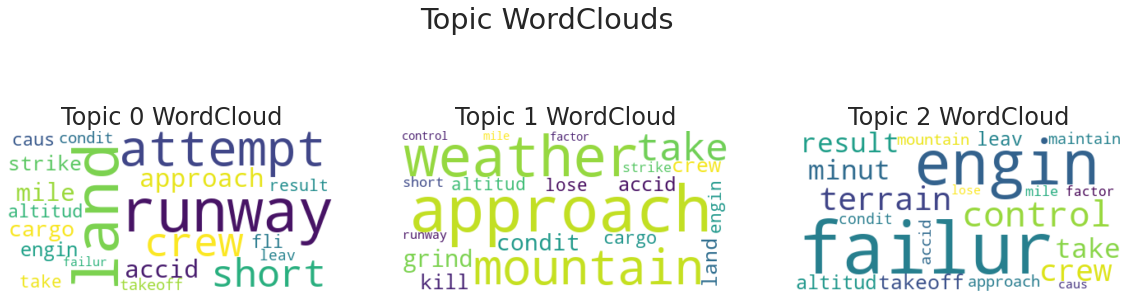

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))
for t in range(lda_model.num_topics):
    # Storing the top 20 frequency words for each topic
    topic_words_freq = dict(lda_model.show_topic(t, topn=20))
    # Generating wordcloud
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq) 
    # Drawing wordcloud
    ax[t].imshow(wordcloud, interpolation='bilinear')
    ax[t].axis("off")
    ax[t].title.set_text(f'Topic {t} WordCloud')
    fig.suptitle(f"Topic WordClouds")

Now, one of the weaknesses of LDA is it does not actually give us a topic name. We do not know what each cluster represents. We have to infer it based off the above wordcloud. Let's additionally print the top summaries in each cluster to get a better idea

In [88]:
for t_no, idx in enumerate(np.argmax(matrix, axis = 0)):
    print(f"Topic {t_no}: {matrix[idx][t_no]}") # Printing topic number and matrix prediction
    print(summary_analysis_data.Summary.iloc[idx]) # Printing summary for it

Topic 0: 0.9544527530670166
While attempting to land at Mitú, the cargo plane's landing gear struck the ground short of the threshold. A go- around was executed but the No. 1 engine was shut down because of low oil pressure. The plane flew over the control tower twice to determine the state of the landing gear. It appeared that part of the left main landing gear was missing. The crew then positioned the plane for an approach and landing. As the plane turned into long final, it struck the ground, crashed in a meadow and caught fire.
Topic 1: 0.9322534799575806
Struck a mountain. The pilot inadequately evaluating the en route weather conditions, and the pilot making the in-flight decision to continue VFR flight into adverse weather conditions. Factors in this accident were the inability of the pilot to see and avoid the mountainous terrain due to the thunderstorms.
Topic 2: 0.9783785343170166
Two minutes after taking off, the air ambulance crashed into Otay peak,  in an isolated area of 

Combining the wordcloud with the above top summaries helped us come up with these 3 topics of common reasons for crashes

**Topic 0: Hardware/Fuel failure** (Coming from Cargo, and the oil issue)

**Topic 1: Weather/Altitude Issues** (Coming mostly from mountain and weather as well as top summary)

**Topic 2: Communication/Crew issues** (Coming from  Crew and Control as well as the top summary)

Finally let's see how many of each topic exist in our summaries. First we need to get the topic IDs and encode them as Strings for all our summaries

In [89]:
topics_int = (np.argmax(matrix, axis = 1)) # Get's integer IDs of topics
topics_str = np.empty(topics_int.shape, dtype='U25') # Creates empty string array to store topic strings
# Stores topic strings for each ID
topics_str[topics_int == 0] = 'Hardware/Fuel failure'
topics_str[topics_int == 1] = 'Weather/Altitude Issues'
topics_str[topics_int == 2] = 'Communication/Crew issues'

Now let's draw a Pie Chart to view the proportion of summaries in each topic

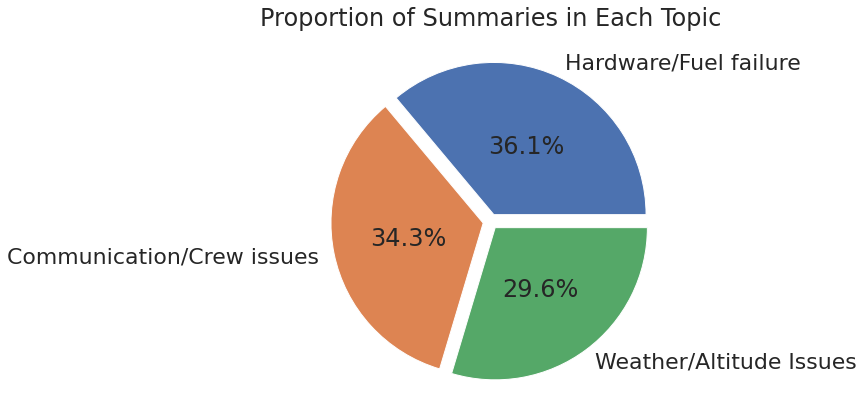

In [90]:
pie, ax = plt.subplots(figsize=[10,7])
labels = pd.Series(topics_str).value_counts().index
plt.pie(x=pd.Series(topics_str).value_counts(), autopct="%.1f%%", explode=[0.05]*3, labels=labels, pctdistance=0.5)
plt.title("Proportion of Summaries in Each Topic");

To view the exact numbers we can use a Bar Chart

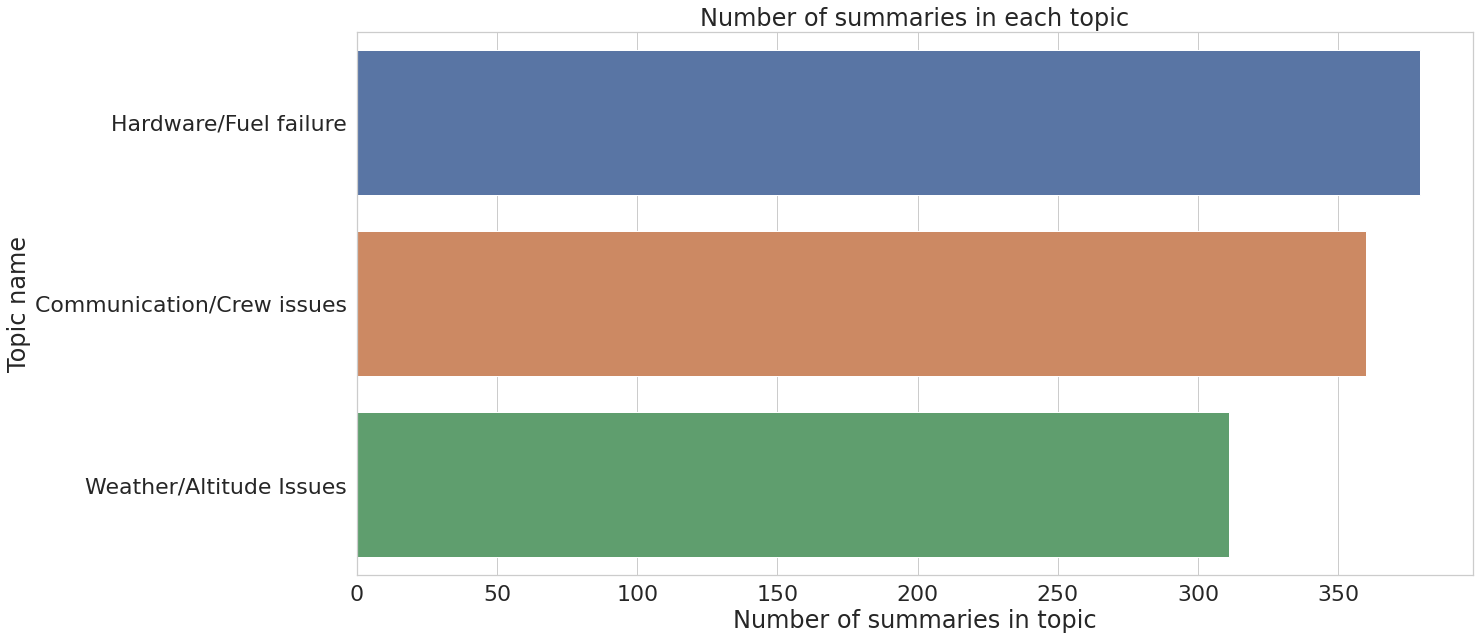

In [91]:
plt.figure(figsize=(20,10))
sns.barplot(x = pd.Series(topics_str).value_counts().values, y = pd.Series(topics_str).value_counts().index)
plt.title("Number of summaries in each topic")
plt.ylabel("Topic name")
plt.xlabel("Number of summaries in topic")
plt.show()

Overall there seems to be an even distribution. We were able to get the major factors for crashes thanks to the summary dataset. However, due to low sample size, we may not have enough data to really segregate each topic. There could be more focused topics. For example, when cleaning the Country column of our dataframe, there were few summaries mentioning war

## Does a country with higher GDP contribute to a higher average fatalities among airline crashes?

Now, we want to explore the relationship between average fatalities for a country and nominal GDP. Note that we are using the flight's destination. 

In [92]:
#select relevant columns
df = airplane_crashes.merge(gdp_data, on='Country')[['Fatalities', 'Nominal GDP Per Capita in US Dollars', 'Country']]

In [93]:
#group crashes by country
df_country = df.groupby('Country').agg({'Fatalities': ['mean', 'count'], 'Nominal GDP Per Capita in US Dollars': ['mean']})
df_country.columns = ['mean_fatalities', 'count', 'mean_gdp']

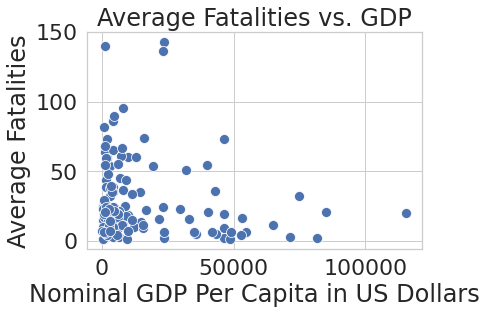

In [94]:
#scatterplot
sns.scatterplot(x='mean_gdp', y='mean_fatalities', data=df_country, s=100)
plt.title('Average Fatalities vs. GDP')
plt.xlabel('Nominal GDP Per Capita in US Dollars')
plt.ylabel('Average Fatalities');

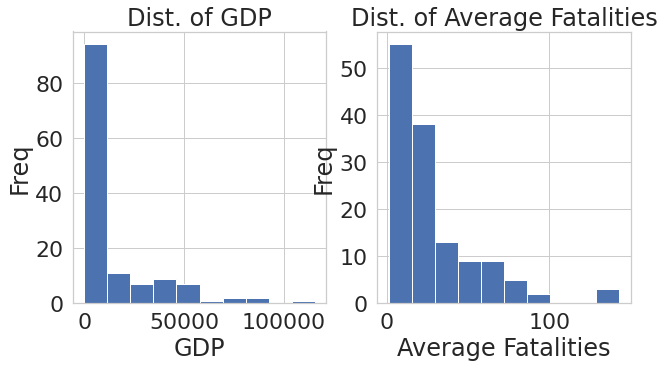

In [95]:
plt.figure(figsize=(10,5))
plt.subplot(121, title='Dist. of GDP', xlabel='GDP', ylabel='Freq')
df_country['mean_gdp'].hist()
plt.subplot(122, title='Dist. of Average Fatalities', xlabel='Average Fatalities', ylabel='Freq')
df_country['mean_fatalities'].hist()
plt.show()

Each country of the scatterplot is represented by a dot. Visually the graph shows an exponential decay curve, suggesting that countries with higher GDPs have lower average fatalities, while countries with lower GDPs have more variability. But let's keep digging.

In [96]:
#test normality on data
st_fatalities, p_fatalities = stats.normaltest(df_country['mean_fatalities'].values)
st_gdp, p_gdp = stats.normaltest(df_country['mean_gdp'].values)

#print p-values
print('Normal test p-value for fatalities: ' + str(p_fatalities))
print('Normal test p-value for gdp: ' + str(p_gdp))

Normal test p-value for fatalities: 9.440392842825162e-15
Normal test p-value for gdp: 8.217255285241981e-17


Neither of these variables are normally distributed. Graphically, they are skewed right. Their p-values are below the significance level of 0.05, so we reject the null hypothesis that the data are normally distributed.

In [97]:
#log(0) is undefined
df_country['mean_fatalities'] = df_country['mean_fatalities'].replace({0: 0.1})

#apply log transformation
df_country['fatalities_10'] = np.log10(df_country['mean_fatalities'])
df_country['gdp_10'] = np.log10(df_country['mean_gdp'])

We apply a log transformation to each to make them more normally distributed. We replace the countries that had 0 average fatalities with 0.1 because log(0) is undefined.

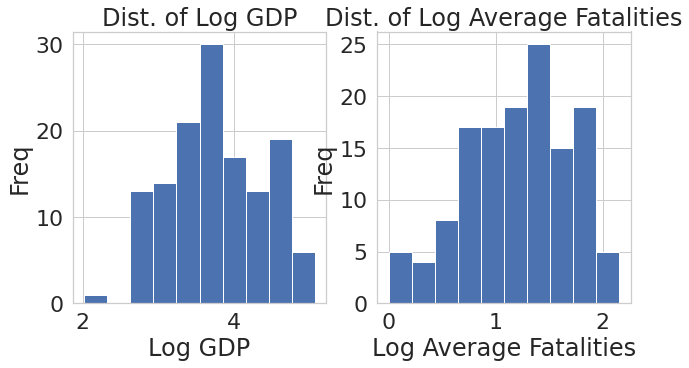

In [98]:
plt.figure(figsize=(10,5))
plt.subplot(121, title='Dist. of Log GDP', xlabel='Log GDP', ylabel='Freq')
df_country['gdp_10'].hist()
plt.subplot(122, title='Dist. of Log Average Fatalities', xlabel='Log Average Fatalities', ylabel='Freq')
df_country['fatalities_10'].hist()
plt.show()

In [99]:
#test normality on transformed data
st_fatalities_10, p_fatalities_10 = stats.normaltest(df_country['fatalities_10'].values)
st_gdp_10, p_gdp_10 = stats.normaltest(df_country['gdp_10'].values)

#print p-values
print('Normal test p-value for fatalities (log transformed): ' + str(p_fatalities_10))
print('Normal test p-value for gdp (log transformed): ' + str(p_gdp_10))

Normal test p-value for fatalities (log transformed): 0.1054619714501513
Normal test p-value for gdp (log transformed): 0.23756619049248423


After doing the log transformation, our data looks normally distributed. The p-values are above 0.05, so we are are unable to reject the null hypothesis, the null hypothesis being that they are normally distributed. Now we can plot these to see if we see a linear relationship.

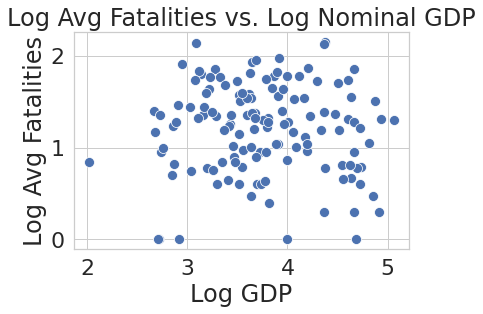

In [100]:
sns.scatterplot(x='gdp_10', y='fatalities_10', data=df_country, s=100)
plt.title('Log Avg Fatalities vs. Log Nominal GDP')
plt.xlabel('Log GDP')
plt.ylabel('Log Avg Fatalities');

Even after doing log transformation, there does not appear to be a strong linear association between log transformed average GDP and fatalities. It appears to be scattered randomly. What happens when we fit linear regression?

In [101]:
#define a function for linear regression
def func_linear_regression(x, m, b):
    return m*x+b

In [102]:
m, b = np.polyfit(df_country['gdp_10'].values, df_country['fatalities_10'].values, 1)
print('Value of the slope is: ' + str(m))
print('Value of the intercept is: ' + str(b))

Value of the slope is: -0.029693105309117524
Value of the intercept is: 1.3199019409445896


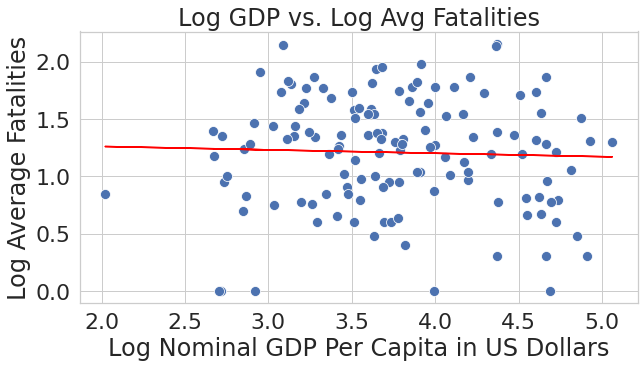

In [103]:
plt.figure(figsize=(10,5))

#plot the original
sns.scatterplot(x='gdp_10', y='fatalities_10', data=df_country, s=100)
plt.xlabel('Log Nominal GDP Per Capita in US Dollars')
plt.title('Log GDP vs. Log Avg Fatalities')
plt.ylabel('Log Average Fatalities');

#plot the predicted
# m, b = np.polyfit(df_country['gdp_10'].values, df_country['fatalities_10'].values, 1)
yfit = func_linear_regression(df_country['gdp_10'], m, b)
plt.plot(df_country['gdp_10'], yfit, 'Red')

plt.show()

Visually, the data points look evenly scattered, and the regression line looks nearly horizontal with a very slight decline. The regression is line is about 1-1.25 log average fatalities for all log GDP values.

In [104]:
y_fatalities, x_gdp = patsy.dmatrices('fatalities_10 ~ gdp_10', df_country)

mod2 = sm.OLS(y_fatalities, x_gdp)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:          fatalities_10   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1886
Date:                Tue, 16 Mar 2021   Prob (F-statistic):              0.665
Time:                        21:42:22   Log-Likelihood:                -93.375
No. Observations:                 134   AIC:                             190.7
Df Residuals:                     132   BIC:                             196.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3199      0.261      5.058      0.0

The $\beta$ estimate for `gdp_10` is 1.3199, but this is on the log scale. 

$$log_{10}(\text{mean_fatalities}) = 1.3199  -0.0297    * log_{10}(\text{mean_gdp}) $$

$$\text{mean_fatalities} = 10^{1.3199  -0.0297   * log_{10}(\text{mean_gdp})} $$

The results of the linear regression tell us a few things. For every 10 fold increase in mean_gdp, log(mean_fatalities) is expected to decrease by $0.0297 $. The p-value (0.665) is high and R-squared is low (0.001), signs that the log transformation of our mean fatalities and mean gdp do not have a strong linear relationship.

Now let's do a t-test, to see if the differences in average fatalities are significant between countries with high/low GDP. So we will label GDPs as high if they are greater than the median GDP, and low if they are less than or equal to the median GDP.

In [105]:
median_gdp = df_country['gdp_10'].median()
print('The median GDP is: ' + str(median_gdp))

The median GDP is: 3.7098702730118567


In [106]:
# 0 for low gdp, 1 for high gdp
df_country['gdp_type'] = (df_country['gdp_10'] > median_gdp).astype(int)

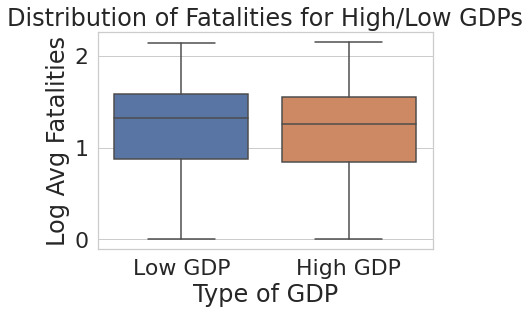

In [107]:
#view relationship between fataliies and gdp through a boxplot
df_country_labeled = df_country.copy()
df_country_labeled['gdp_type'] = df_country_labeled['gdp_type'].replace({0:'Low GDP', 1:'High GDP'})
sns.boxplot(x='gdp_type', y='fatalities_10', data=df_country_labeled)
plt.title('Distribution of Fatalities for High/Low GDPs')
plt.xlabel('Type of GDP')
plt.ylabel('Log Avg Fatalities');

In [108]:
df_country.groupby(['gdp_type'])['fatalities_10'].mean()

gdp_type
0    1.230385
1    1.185718
Name: fatalities_10, dtype: float64

The blue represents countries with low GDP. The orange represents countries with high GDP. The range of log fatalities are similar from 0-2.5. The median fatalities for low GDP countries is slightly higher than that for high GDP countries.

Let's do a t-test to see if these two groups are significantly different.

In [109]:
group1 = df_country.where(df_country.gdp_type==0).dropna()['fatalities_10']
group2 = df_country.where(df_country.gdp_type==1).dropna()['fatalities_10']

In [110]:
ttest_ind(group1, group2)

Ttest_indResult(statistic=0.5284460366534165, pvalue=0.5980771492425014)

The p-value of our t-test is 0.598. This is greater than our significance level of 0.05, meaning we cannot reject the null hypothesis. This means that there is no significant difference in average fatalities between high GDP countries and low GDP countries. 

Our original hypothesis was high GDP countries would have higher fatalities because they may tend to operate more flights. However the results of our linear regression and t-test show that there is no relationship between a country's GDP and its average fatalities.

## Does the likelihood of an airline crash depend on the daylight conditions in that timezone?

First, let's convert the strings to a datetime object and extract the hour of day of the crash in UTC

In [111]:
airplane_crashes.Time = pd.to_datetime(airplane_crashes.Time, format="%H:%M", errors='coerce')
airplane_crashes['Hour'] = airplane_crashes.Time.dt.hour
airplane_crashes.dropna(subset=['Hour'], inplace=True)
airplane_crashes.Hour = airplane_crashes.Hour.astype(int)
airplane_crashes.head()

,Date,Time,Operator,Type,Aboard,Fatalities,Summary,Country,Year,Hour
0,1990-02-05,1900-01-01 08:37:00,Helicopteros Nacionales de Colombia,Grumman G-159 Gulfstream I,15.0,15.0,"Struck Mt. El Saluda at 5,000 ft., near Image,...",Colombia,1990,8
1,1990-01-02,1900-01-01 13:40:00,Pelita Air Service,CASA 212 Aviocar 200,16.0,9.0,Ditched into the Java Sea after experiencing m...,Indonesia,1990,13
2,1990-01-13,1900-01-01 12:56:00,Aeroflot,Tupolev TU-134A,71.0,27.0,A fire in the rear cargo hold and fire warning...,Russia,1990,12
3,1990-01-15,1900-01-01 08:30:00,SANSA,CASA 212 Aviocar 200,23.0,23.0,"Crashed about 4,500 feet up on 7,250 ft. Pico ...",Costa Rica,1990,8
4,1990-01-17,1900-01-01 07:19:00,Federal Express,Cessna 208A Caravan I Cargomaster,1.0,1.0,"The cargo plane crashed into a 14,200 ft. Moun...",United States,1990,7


Now, let's visualize how the distribution of crashes looks like

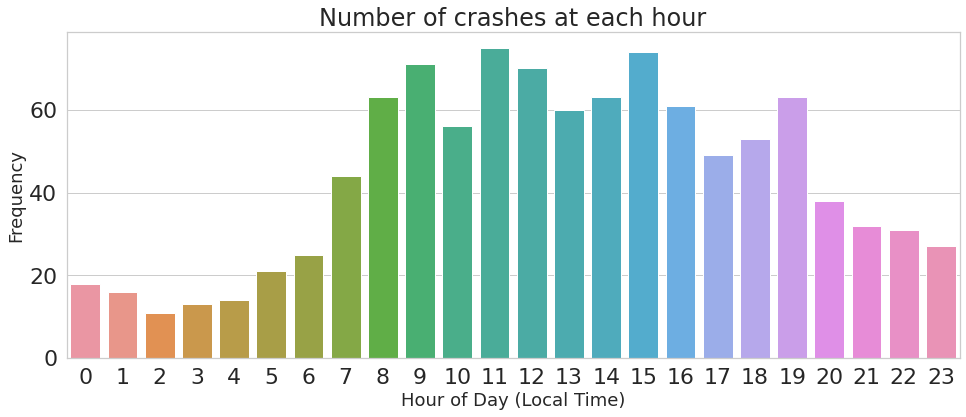

In [112]:
_, ax = plt.subplots(figsize=(16, 6))
sns.countplot(airplane_crashes.Hour, ax=ax);
ax.set_title('Number of crashes at each hour');
ax.set_xlabel('Hour of Day (Local Time)', fontsize=18);
ax.set_ylabel('Frequency', fontsize=18);

It seems like crashes occur more frequently in day time compared to night time. This seems like an easy answer to our question, but the actual answer is trickier than that. The reason for that is because we don't have the data for the number of crashes that do not occur.

Recognizing this flaw in the analysis, we can still test our hypothesis that crashes occur more frequently in the daytime than nighttime with a p-test by computing the **chi-square values**.

$H_0 = $ Number of crashes are uniformly distributed across every hour of day

$H_A = $ Number of crashes are not uniformly distributed across every hour of day

In [113]:
stats.chisquare(airplane_crashes.Hour.value_counts(normalize=True))

Power_divergenceResult(statistic=0.24210418973253311, pvalue=1.0)

We can very confidently **reject our null hypothesis** (p=1) that the crashes occur randomly at any given hour and there does seem to bias towards daytime hours for crashes to occur but again this might just be because more planes tend to fly during day hours.

# Ethics & Privacy

### Concerns with data collection

We are using an already published public dataset. The dataset has been published by OpenData. Moreover it does not maintain any PII and is licensed appropriately. The data is distributed under the OpenData license: https://opendatacommons.org/licenses/odbl/1-0/ and as such can be used by us in our project. Since we will also be scraping some data we have also taken care not to spam any website with requests and follow the policy in robots.txt

### Concerns with data storage

Since we are using an already published dataset we can’t do much to secure it (already available to others). Once again there is no PII stored in it. Our Github repository is private and has proper access control set up to only allow authorized people to view.

### Concerns with data analysis

Currently an important assumption we are making is that the relative ranking of the nations haven't changed too much over the past 20 years in terms of nominal GDP. There are actual changes in the nominal GDP for sure but we are more interested in the relative ranking.  We have also made controversial location changes like Taiwan -> China. These are in accordance to how the UN defines it and we mean no harm in these changes. This analysis shows the current trend and cannot be a perfect representation of the future (especially during the pandemic)
* During analysis of the LDA topic clustering, we need to keep in mind that 1000 samples may not be enough for the LDA algorithm to properly cluster. Moreover, our inference of topics isn't perfect. Especially in Topic 0 where we had to dig into the data further to understand it's topic. 3 topics may be too less to represent all the major groups but with 1000 samples we had to use only 3 topics to reduce the bias
* During analysis of the relationship b/w nominal GDP of a country and number of fatalities we would have liked to have more accuracy in reporting all the crashes in the past 30 years instead of the ones in US. This did introduce variance that can affect our analysis
* During analysis of the relationship b/w daytime conditions and the likelihood of an airplane crash we were affected by the fact that our dataset did not contain information that would give us number of crashes not occuring. We ran a Chi Squared to limit this but our analysis would be more conclusive given that information

### Concerns after deployment

Currently, we don’t envision any severe consequences/further damage to the underprivileged. We have given a final read through before deployment as a team to ensure that there are no unintended consequences and assumptions and scope are clearly stated. If after deployment something does come up we will modify it accordingly. Our expected impact after deployment is that airline companies will know some of the common factors correlated with airline crashes and be able to adjust it. For example, the topic analysis points to better training of crew, more safety checks of airplane before sending for flight and proper weather monitoring to avoid accidents in case of harsh weather

# Conclusion & Discussion

### What are the major factors noticed during crashes?
Our analysis has found that the major factors for airplane crashes are hardware issues, communication issues and weather related issues. Each of them roughly encompass 33% of crashes indicating that these are issues to be paid attention to.

However, we are unable to cluster completely due to the lower number of samples. To handle the lower number of samples we reduced the number of topics to reduce the effect of bias. The topics we have found do encompass a wide range of issues but do not provide more specific information. We would need a higher number of samples so that we can use more topics to get more specific information.

### Does a country with higher GDP contribute to a higher average fatalities among airline crashes?

The average fatalities for a country are not significantly impacted by its GDP. Our analysis on linear regression and log transformation showed no linear relationship. Additionally, our t-test showed that we cannot reject our null hypothesis (that there is a significant difference in average fatalities between high/low GDPs. We conclude that a country with higher GDP does not contribute to higher average fatalities.

However, we may not have access to all of the flight crashes in the past 30 years, because a majority of them were from the United States. There was variance among the number of crashes reported for each country, some had significantly less or more. If we had more data, we could better represent the fatalities for each country. For our analysis we used average fatalities to make a more fair comparison.

### Does the likelihood of an airline crash depend on the daylight conditions in that timezone?

Our analysis indicated that there was a correlation b/w the likelihood of an airplane crash and the time of the day. Specifically there were more crashes happening during the daytime. We use a Chi Squared test to determine if the likelihood of an airplane crash is uniform in a day or does it depend on the daylight conditions in that timezone

However, we do not have information on the number of crashes that do not occur and hence our analysis is limited without knowing this information. We run a Chi squared test to combat this issue but ideally we would like to have more information on the number of crashes not occuring. Also we do not have access to all flight crashes in past 30 years and this may bias the analysis

### How was this useful?

We hope the insights gained during this analysis helps contribute to a better understanding in what factors contribute to a safer or riskier flight. This analysis could inform airlines of the most important factors to be thinking about when it comes to safety regulations, leading to safer travel for flight passengers

# Team Contributions

Catherine worked on the Background, Data Cleaning (imputing/assessing nulls on the airplane crash dataset), EDA (Faithfulness), and GDP vs. Fatalities Analysis. 

Kaixin worked on the Data Cleaning (imputing/assessing nulls on the airplane crash dataset), EDA (Temporality), and GDP vs. Fatalities Analysis.

Siddharth worked on the Data Loading (GDP + State names), Data Cleaning (Specifically country column), EDA (Structure + Granularity portion), Ethics and Privacy as well as the LDA algorithm used to find the major topics

Advitya worked on drafting the research questions and hypothesis, finding the datasets, assisted in data cleaning (lookup dictionary for detecting countries) and EDA visualizations (for a couple seaborn plots showcasing NaN values), ethics and privacy section (related to context and scope of the problem and dynamics of country names dependent on time), and formulated the template and flow of the slides and it's EDA portion. 

Devanshu worked on the third analysis question where he studied the relationship between daylight and the frequency of crashes. He also did the Scope section of the EDA as well as worked with Advitya on drafting research questions, hypothesis and finding the datasets